<a href="https://colab.research.google.com/github/justdepie/MSc-Thesis-From-Tables-to-Natural-Language-Summaries/blob/main/DataPreparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Functions**

In [ ]:
#some stats about text length
import statistics as st

def text_length_stats(df, subset):
    print(f"Text Length Stats-{subset.capitalize()} Set:")

    columns = ['final_sentence', 'table_page_title', 'table_section_title', 'table_section_text']
    for col_name in columns:
        text_len = [len(text) for text in df[col_name]]
        print(f"\n{col_name.replace('_', ' ').title()}:")
        print('The average text length is', int(st.mean(text_len)), 'characters.')
        print('The standard deviation of text length is', int(st.stdev(text_len)), 'characters.')
        print('The minimum text length is', int(min(text_len)), 'characters.')
        print('The maximum text length is', int(max(text_len)), 'characters.')

In [ ]:
#checking for html tags
import re

def html_tags_scan(df_column):
  html_pattern = re.compile(r'<(p|h[1-6]|a|img|ul|ol|li|div|span|table|tr|td|strong|em|br|hr)[^>]*>')
  html_tags_count = 0
  for i in range(len(df_column)):
    if html_pattern.search(df_column[i]):
        html_tags_count  +=1
  print(f"{df_column} : The number of records containing HTML tags is {html_tags_count}")

In [ ]:
# Function to get the max number of cells per row for a table
def get_max_cells_per_row(table):
    max_cells_per_row = 0

    for row in table:
        num_cells = len(row)
        max_cells_per_row = max(max_cells_per_row, num_cells)

    return max_cells_per_row

In [ ]:
import numpy as np

def has_mismatched_rows(table):
    for row in table:
        if isinstance(row, np.ndarray) and all(isinstance(cell, dict) for cell in row):
            max_cell = get_max_cells_per_row(table)
            cell_count = len(row)

            if max_cell != cell_count:
                return True

    return False

In [ ]:
def count_mismatched_rows(table):
    # Initialize a counter for mismatched rows
    mismatched_count = 0

    # Iterate over each row in the table
    for row in table:
        # Check if the row is a list of dictionaries
        if isinstance(row, np.ndarray) and all(isinstance(cell, dict) for cell in row):
            max_cells = get_max_cells_per_row(table)
            cell_count = len(row)

            # Check if the number of cells doesn't match the number of headers
            if max_cells != cell_count:
                mismatched_count += 1

    return mismatched_count

In [ ]:
def get_tables_with_col_span_dif_1(subset):
  #number of tables that have col_span!=1
  table_count = 0
  for table in subset['table']:
      has_column_span_not_equal_to_1 = any('column_span' in cell and cell['column_span'] != 1 for row in table for cell in row)
      if has_column_span_not_equal_to_1:
          table_count += 1
  #getting the indexes of those tables
  table_indices = []
  for i, table in enumerate(subset['table']):
      has_column_span_not_equal_to_1 = any('column_span' in cell and cell['column_span'] != 1 for row in table for cell in row)
      if has_column_span_not_equal_to_1:
          table_indices.append(i)
  return table_count,table_indices

In [ ]:
from tqdm import tqdm

#creating a dict with the max row span of each table
#the key is the table and the value is the max row span

def get_max_rs_of_all_tables(subset):
  max_rs_dict = {}

  for t in range(len(subset['table'])):
      table = subset['table'][t]
      max_row_span_table = 0

      for r in range(len(table)):
          row = subset['table'][t][r]

          for c in range(len(row)):
              cell = subset['table'][t][r][c]
              current_row_span = cell.get('row_span', 0)  # Get row_span or default to 0

              # Update max_row_span_table if a larger row_span is found in the current row
              if current_row_span > max_row_span_table:
                  max_row_span_table = current_row_span

      max_rs_dict[t] = max_row_span_table

  return max_rs_dict

Below is the function that has been used to fill in the missing cells.

In [ ]:
import multiprocessing
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def process_table(args):
  try:
    subset, table_index, max_cells_per_row_dict, val_max_rs = args
    max_cells = max_cells_per_row_dict[table_index]
    data = subset['table'][table_index]
    logger.debug(f"Data for table {table_index}: {data}")


    # Making a dict out of cell values,row span and column span
    organized_data = {}
    for i in range(len(data)):
        for j in range(len(data[i])):
            cell_values = list(data[i][j].values())
            key = i
            value = cell_values[-1]  # Taking the values
            value2 = cell_values[-2]  # Taking the row span
            value3 = cell_values[0]  # Taking the column span

            if key not in organized_data:
                organized_data[key] = [(value2, value, value3)]
            else:
                organized_data[key].append((value2, value, value3))

    # Adding missing dicts according to column span
    result_dict = {}
    for key, tuples_list in organized_data.items():
        repeated_tuples = []
        for tpl in tuples_list:
            rs, value, cs = tpl
            repeated_tuples.extend([(rs, value, cs)] * cs)
        result_dict[key] = repeated_tuples

    # Adding missing dicts according to row span
    for j in range(max_cells):
        for i in range(len(result_dict)):
            if i in result_dict and j < len(result_dict[i]):
                value = result_dict[i][j]
                for rs in range(2, val_max_rs[table_index] + 1):
                    if value[0] == rs:
                        tuple1 = (1, value[1], 1)
                        for k in range(1, rs):
                            if i + k in range(len(result_dict)):
                                result_dict[i + k].insert(j, tuple1)

    # Count the number of tuples per key
    tuple_counts = {key: len(values) for key, values in result_dict.items()}

    # Find the maximum count
    max_count = max(tuple_counts.values())

    # Add ("", "", "") tuple where the count is not the same across keys
    for key in result_dict.keys():
        current_count = tuple_counts.get(key, 0)
        if current_count < max_count:
            diff = max_count - current_count
            result_dict[key].extend([("", "", "")] * diff)

    #new_result_dict = {key: [value[1] for value in values] for key, values in result_dict.items()}
    return result_dict #new_result_dict

  except Exception as e:
        return None

def process_tables_parallel(subset, table_indexes, max_cells_per_row_dict, max_rs):
  try:
    # Prepare arguments for the pool.map function
    args_list = [(subset, table_index, max_cells_per_row_dict, max_rs) for table_index in table_indexes]

    # Use multiprocessing pool
    with multiprocessing.Pool() as pool:
        processed_results_parallel = pool.map(process_table, args_list)

    return processed_results_parallel

  except Exception as e:
        return None

  finally:
        # Explicitly close and join the pool
        pool.close()
        pool.join()



In [ ]:
#extracting the number of rows and columns
from tqdm import tqdm
import pandas as pd

def get_num_row_col(subset):
  num_row_col={}
  for t in tqdm(range(len(subset))):
    num_rows, num_columns = pd.DataFrame(subset['processed_table'][t]).T.shape
    num_row_col[t]=[num_rows, num_columns]
  return num_row_col


The function below is used to convert the tables to text format.

In [ ]:
import gc
import pandas as pd
import numpy as np

def text_from_table(subset,table_number):
    tn=table_number
    table = pd.DataFrame(subset['processed_table'][tn]).T

    # Get the rows with all same values
    all_same_values_indexes = table.index[table.apply(lambda row: row.nunique() == 1, axis=1)].tolist()

    few_same_values = table.index[table.apply(lambda row: any(row[i] == row[i + 1] for i in range(len(row) - 1)), axis=1)].tolist()

    template_text_from_table = ""
    template_list=list()

    # Function to check for consecutive identical values in a single column
    def has_consecutive_identical_values(column):
        return any(column[i][1] == column[i + 1][1] for i in range(len(column) - 1))

    # Case 1: Having multiple same value rows that follow a pattern and are not subcategories (like episode summaries)
    if all_same_values_indexes and (all(all_same_values_indexes[i] == 2 * i + 2 for i in range(len(all_same_values_indexes))) or all(all_same_values_indexes[i] == 2 * i + 1 for i in range(len(all_same_values_indexes)))):
      gc.collect()
      # Set the second value of each tuple as the header
      table.columns = table.iloc[0].apply(lambda x: x[1])
      # Drop the first row (if it was used to set the header)
      table = table.iloc[1:]
      for  _,row in table.iterrows():
        if _ in all_same_values_indexes:
        # Remove duplicate values from the row
          unique_values = set(value[1] for value in row)
          row_text = ", ".join(unique_values)
          template_text_from_table += row_text + ". "
        else:
          row_text = ", ".join(f"{column} is {value[1]}" for column, value in zip(table.columns, row))
          template_text_from_table += row_text + ". "

    # Case 2: Having subcategories - Break Df into subdfs
    elif len(all_same_values_indexes)>=1:
      subdfs = []
      for i in range(len(all_same_values_indexes) - 1):
          gc.collect()
          start_index = all_same_values_indexes[i]
          end_index = all_same_values_indexes[i + 1] - 1
          selected_rows = table.loc[start_index:end_index]
          subdfs.append(selected_rows)

          # Set combination of values in the first two rows as headers
          header_values = selected_rows.iloc[:2, :].apply(lambda x: ' '.join(list(str(item[1]) for item in x if isinstance(item, tuple))))
          unique_headers = [header_values.iloc[0]] + [col for col in header_values.iloc[1:] if col not in header_values.iloc[:1]]
          selected_rows.columns = unique_headers

          # Drop the rows that became headers
          selected_rows = selected_rows.iloc[2:, :]
          subdfs[-1] = selected_rows

      # Add the last set of rows (from the last index to the end)
      if all_same_values_indexes:
          last_start_index = all_same_values_indexes[-1]
          selected_rows_last = table.loc[last_start_index:]
          subdfs.append(selected_rows_last)

          header_values_last = selected_rows_last.iloc[:2, :].apply(lambda x: ' '.join(list(str(item[1]) for item in x if isinstance(item, tuple))))
          unique_headers_last = [header_values_last.iloc[0]] + [col for col in header_values_last.iloc[1:] if col not in header_values_last.iloc[:1]]
          selected_rows_last.columns = unique_headers_last

          selected_rows_last = selected_rows_last.iloc[2:, :]
          subdfs[-1] = selected_rows_last

      for df in subdfs:
        gc.collect()
        for _, row in df.iterrows():
            row_text = ", ".join(f"{header} is {value[1]}" for header, value in zip(df.columns, row))
            template_text_from_table += row_text + ". "

    # Case 3: Few repeated consecutive cells
    elif len(few_same_values) >=1 :

      # Iterate through columns and check for consecutive identical values in the first two rows
      for column in range(len(table.columns)):
          first_two_rows = table.iloc[:, column].head(2).tolist()
          #Need for combo headers
          if has_consecutive_identical_values(first_two_rows) or any(table[column].apply(lambda x: isinstance(x, list) and len(x) >= 3 and x[2] >= 3)):
            break

      if has_consecutive_identical_values(first_two_rows) or any(table[column].apply(lambda x: isinstance(x, list) and len(x) >= 3 and x[2] >= 3)):
        # Combine the second tuple values of the first two rows as the column headers
        combined_headers = table.iloc[:2].apply(lambda row: ' '.join(x[1] for x in row), axis=0)
        unique_headers=list()
        for i in range(len(combined_headers)):
          gc.collect()
          input_string = combined_headers[i]
          #dropping repeating words
          result_list = list(map(lambda word: word[0], list(map(lambda word: (word, 1), input_string.split()))))
          result_string = ' '.join(result_list)
          unique_headers.append(result_string)

        # Set the combined headers
        table.columns = unique_headers
        # Drop the first two rows (if they were used to set the headers)
        table = table.iloc[2:]

        for  _,row in table.iterrows():
          row_text = ", ".join(f"{column} is {value[1]}" for column, value in zip(table.columns, row))
          template_text_from_table += row_text + ". "

      # No need for combo header
      else:
        gc.collect()
        table= pd.DataFrame(subset['processed_table'][tn]).T
        # Set the second value of each tuple as the header
        table.columns = table.iloc[0].apply(lambda x: x[1])
        # Drop the first row (if it was used to set the header)
        table = table.iloc[1:]
        for  _,row in table.iterrows():
          if _ in all_same_values_indexes:
          # Remove duplicate values from the row
            unique_values = list(value[1] for value in row)
            row_text = ", ".join(unique_values)
            template_text_from_table += row_text + ". "
          else:
            row_text = ", ".join(f"{column} is {value[1]}" for column, value in zip(table.columns, row))
            template_text_from_table += row_text + ". "

    # Case 4: Normal Tables
    elif all_same_values_indexes==[] and few_same_values==[]:
      gc.collect()
      # Set the second value of each tuple as the header
      table.columns = table.iloc[0].apply(lambda x: x[1])
      # Drop the first row (if it was used to set the header)
      table = table.iloc[1:]
      for  _,row in table.iterrows():
        row_text = ", ".join(f"{column} is {value[1]}" for column, value in zip(table.columns, row))
        template_text_from_table += row_text + ". "

    return template_text_from_table

Now we should clean the texts we created with "text_cleaner". We will remove special characters and check for html tags.

In [ ]:
import regex
import re

# tft: text from table
def text_cleaner(tft):

  template_text_from_table_clean = regex.sub(r"(@[A-Za-z0-9]+)|([^0-9\p{L} \t,.\-()#:°(\d+-\d+)])|(\w+:\/\/\S+)|^rt|http.+", "", tft)
  # Remove HTML tags
  template_text_from_table_clean = re.sub(r'<[^>]+>', '', template_text_from_table_clean)
  # Substitute two dots with one
  template_text_from_table_clean = regex.sub(r'\.{2,}', '.', template_text_from_table_clean)
  #substitute # with Number
  template_text_from_table_clean = template_text_from_table_clean.replace('#', 'Number')
  # Split the cleaned text into words
  words = template_text_from_table_clean.split()
  # Keep only one occurrence of a word if it appears two times in a row
  cleaned_words = [words[0]] + [word2 for word1, word2 in zip(words, words[1:]) if word1 != word2]
  # Join the words back into a string
  template_text_from_table_clean = ' '.join(cleaned_words)

  return template_text_from_table_clean


Function to extract the text indicated by highlighted cell:

In [ ]:
def get_text_from_hc(subset):

  highlighted_text_dict = {}

  for t in range(len(subset['processed_table'])):
      table = pd.DataFrame(subset['processed_table'][t]).T
      hc_all = subset['highlighted_cells'][t]
      highlighted_text=""
      for hc in range(len(hc_all)):
          row = hc_all[hc][0]
          column = hc_all[hc][1]

          if 0 <= row < table.shape[0] and 0 <= column < table.shape[1]:
              highlighted_text+=" "+table.iloc[row, column][1]
              highlighted_text_dict[t] = highlighted_text
          else:
              highlighted_text_dict[t] = None

  return  highlighted_text_dict


Function to clean hc text:

In [ ]:
def clean_hc_text(hc_dict):
  for k in hc_dict.keys():
      if hc_dict[k] is not None:
          hc_dict[k] = regex.sub(r'\s+', ' ', hc_dict[k])
          hc_dict[k] = regex.sub(r"(@[A-Za-z0-9]+)|([^0-9\p{L} \t,.\-()#:°(\d+-\d+)])|(\w+:\/\/\S+)|^rt|http.+", "", hc_dict[k])
          # Remove HTML tags
          hc_dict[k] = re.sub(r'<[^>]+>', '', hc_dict[k])
          # Substitute two dots with one
          hc_dict[k] = regex.sub(r'\.{2,}', '.', hc_dict[k])
          # Substitute # with Number
          hc_dict[k] = hc_dict[k].replace('#', 'Number')
          # Split the cleaned text into words
          words = hc_dict[k].split()
          if words:
            # Keep only one occurrence of a word if it appears two times in a row
            cleaned_words = [words[0]] + [word2 for word1, word2 in zip(words, words[1:]) if word1 != word2]
            # Join the words back into a string
            hc_dict[k] = ' '.join(cleaned_words)

  return hc_dict

Adding the special tokens for Llama2

In [ ]:
#for train, val
def add_tags(subset,text,key):
    return "<s>[INST] Make a summary using the words and numbers between 'Focus on:' and 'Table Structure:'. " + str(text) + " [/INST] " + f"{subset['final_sentence'][key]} </s>"

In [ ]:
#for test
def add_tags_test(text,key):
    return "<s>[INST] Make a summary using the words and numbers between 'Focus on:' and 'Table Structure:'. " + str(text) + " [/INST] </s>"

#**LOADING TOTTO**

In [ ]:
%%capture
!pip install datasets

Since the annotations for the original test set are not provided, I have decided to take 10% of the original training set and use it as a test set.

[Splitting & Slicing Documentation](https://huggingface.co/docs/datasets/v1.11.0/splits.html)

In [ ]:
from datasets import load_dataset

test = load_dataset("totto",split='validation')
train = load_dataset("totto",split='train[:90%]')
validation = load_dataset("totto",split='train[90%:]')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/120761 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7700 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7700 [00:00<?, ? examples/s]

In [ ]:
print("Number of rows per set: \nTrain:",train.num_rows,"\nValidation:",validation.num_rows,"\nTest:",test.num_rows)

Number of rows per set: 
Train: 108685 
Validation: 12076 
Test: 7700


Below we can see the features of each subset.

In [ ]:
print("Train:\n\n",train.features,"\n\nValidation:\n\n",validation.features,"\n\nTest:\n\n", test.features)

Train:

 {'id': Value(dtype='int32', id=None), 'table_page_title': Value(dtype='string', id=None), 'table_webpage_url': Value(dtype='string', id=None), 'table_section_title': Value(dtype='string', id=None), 'table_section_text': Value(dtype='string', id=None), 'table': [[{'column_span': Value(dtype='int32', id=None), 'is_header': Value(dtype='bool', id=None), 'row_span': Value(dtype='int32', id=None), 'value': Value(dtype='string', id=None)}]], 'highlighted_cells': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None), 'example_id': Value(dtype='string', id=None), 'sentence_annotations': Sequence(feature={'original_sentence': Value(dtype='string', id=None), 'sentence_after_deletion': Value(dtype='string', id=None), 'sentence_after_ambiguity': Value(dtype='string', id=None), 'final_sentence': Value(dtype='string', id=None)}, length=-1, id=None), 'overlap_subset': Value(dtype='string', id=None)} 

Validation:

 {'id': Value(dtype='int32

In [ ]:
train_df = train.to_pandas()
test_df = test.to_pandas()
val_df = validation.to_pandas()

In [ ]:
test_df.highlighted_cells.iloc[876]

array([array([1, 1], dtype=int32), array([1, 2], dtype=int32),
       array([1, 3], dtype=int32), array([1, 5], dtype=int32),
       array([1, 6], dtype=int32)], dtype=object)

In [ ]:
del validation,train,test,

In [ ]:
import gc
gc.collect()

5

Text(0.5, 1.0, 'Top 20 most popular domains of ToTTo')

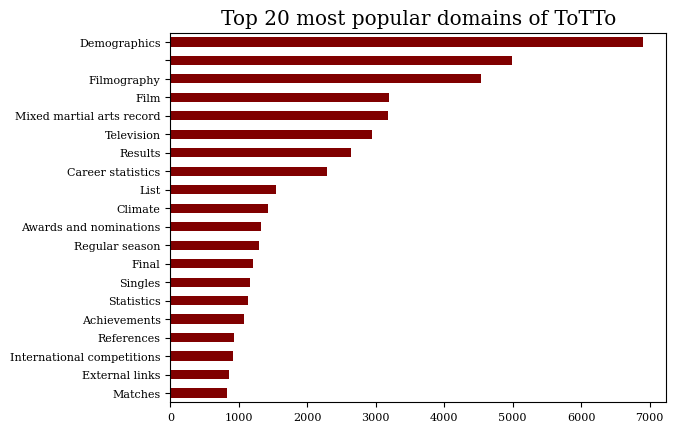

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8

pd.concat([train_df, test_df,val_df], ignore_index=True)['table_section_title'].value_counts().head(20).sort_values(ascending=True).plot(kind='barh',color='maroon')
plt.title('Top 20 most popular domains of ToTTo')

In [ ]:
train_df.tail(3)

,id,table_page_title,table_webpage_url,table_section_title,table_section_text,table,highlighted_cells,example_id,sentence_annotations,overlap_subset
108682,108682,Stade de France,http://en.wikipedia.org/wiki/Stade_de_France,UEFA Euro 2016 matches,,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[7, 2], [7, 4], [7, 5]]",-4271503872550977258,"{'original_sentence': ['Across the next month,...",none
108683,108683,Yellow Book of Lecan,http://en.wikipedia.org/wiki/Yellow_Book_of_Lecan,Contents,The numbering for the texts given below is bot...,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[30, 2], [38, 0], [39, 0]]",3817050467439083949,{'original_sentence': ['The manuscript is writ...,none
108684,108684,List of NHL players with 500 goals,http://en.wikipedia.org/wiki/List_of_NHL_playe...,500-goal scorers,,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[11, 1], [11, 2], [11, 4], [20, 1], [20, 2]]",9091729185354657428,{'original_sentence': ['He reached several mil...,none


In [ ]:
val_df.head(3)

,id,table_page_title,table_webpage_url,table_section_title,table_section_text,table,highlighted_cells,example_id,sentence_annotations,overlap_subset
0,108685,38th Legislative District (New Jersey),http://en.wikipedia.org/wiki/38th_Legislative_...,Election history,"In October 2015, Anthony Cappola left the race...","[[{'column_span': 1, 'is_header': True, 'row_s...","[[27, 0], [28, 0], [28, 1], [28, 2]]",5734530857141214400,{'original_sentence': ['The district is repres...,none
1,108686,2015–16 Mohun Bagan A.C. season,http://en.wikipedia.org/wiki/2015%E2%80%9316_M...,AFC Cup,,"[[{'column_span': 1, 'is_header': False, 'row_...","[[0, 3], [1, 3]]",-3365606750141156603,{'original_sentence': ['In the 116th minute of...,none
2,108687,Ealhmund of Kent,http://en.wikipedia.org/wiki/Ealhmund_of_Kent,External links,Ealhmund 4 at Prosopography of Anglo-Saxon Eng...,"[[{'column_span': 3, 'is_header': True, 'row_s...","[[1, 1]]",-6423163653201019267,"{'original_sentence': ['Finally, in the Canter...",none


In [ ]:
test_df.table_webpage_url.iloc[3]

'http://en.wikipedia.org/wiki/List_of_rulers_of_Brittany'

In [ ]:
test_df['table'].iloc[2758] #table used to explain preprocessing in the report

array([array([{'column_span': 3, 'is_header': True, 'row_span': 1, 'value': 'Designation'},
              {'column_span': 3, 'is_header': True, 'row_span': 1, 'value': 'Discovery'},
              {'column_span': 2, 'is_header': True, 'row_span': 1, 'value': 'Properties'},
              {'column_span': 1, 'is_header': True, 'row_span': 2, 'value': 'Ref'}],
             dtype=object)                                                                 ,
       array([{'column_span': 1, 'is_header': True, 'row_span': 1, 'value': 'Permanent'},
              {'column_span': 1, 'is_header': True, 'row_span': 1, 'value': 'Provisional'},
              {'column_span': 1, 'is_header': True, 'row_span': 1, 'value': 'Citation'},
              {'column_span': 1, 'is_header': True, 'row_span': 1, 'value': 'Date'},
              {'column_span': 1, 'is_header': True, 'row_span': 1, 'value': 'Site'},
              {'column_span': 1, 'is_header': True, 'row_span': 1, 'value': 'Discoverer(s)'},
              

In [ ]:
test_df.overlap_subset.value_counts()

False    3916
True     3784
Name: overlap_subset, dtype: int64

In [ ]:
val_df.overlap_subset.value_counts()

none    12076
Name: overlap_subset, dtype: int64

In [ ]:
train_df.overlap_subset.value_counts()

none    108685
Name: overlap_subset, dtype: int64

#**Processing Tables**

##**Understanding the structure of Tables**
The table field is a `List[List[Dict]]`. The **outer lists** represents **rows** and the **inner lists** **columns**.

Each Dict has the fields:
* column_span (int) : Specifies the number of columns that a cell should span horizontally.
* row_span (int) :  Specifies the number of rows that a cell should span vertically.
* is_header (bool)
* value (str)


([Source](https://github.com/google-research-datasets/ToTTo))

Let's see how the 5th table of the validation set looks like:






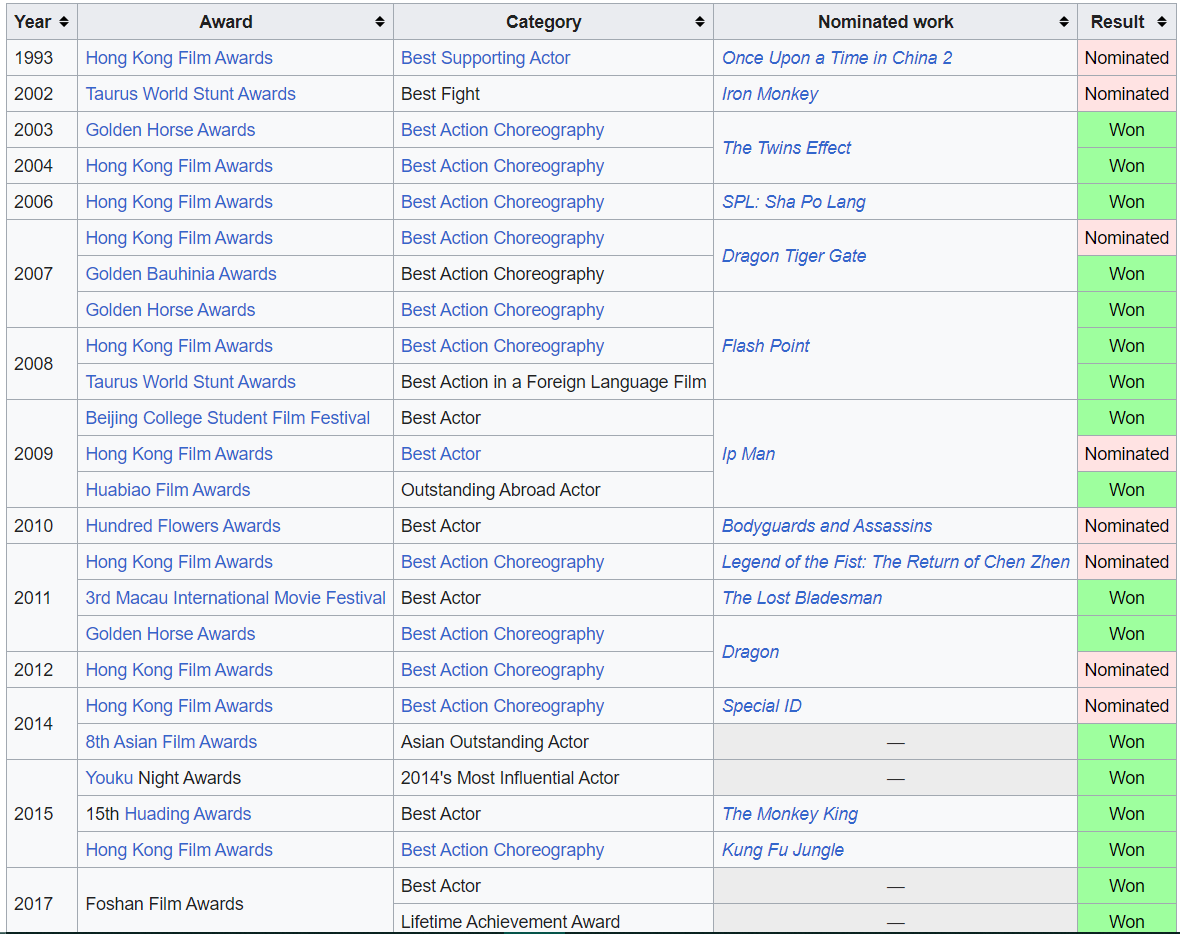

The screenshot below highlights an instance where a mismatch occurs. In the first array (record), the number of dicts (cells) matches the headers, while in the second one, there is one less dict (cell).If we observe the image above, it appears that the "Nominated Work" is the same for both years.

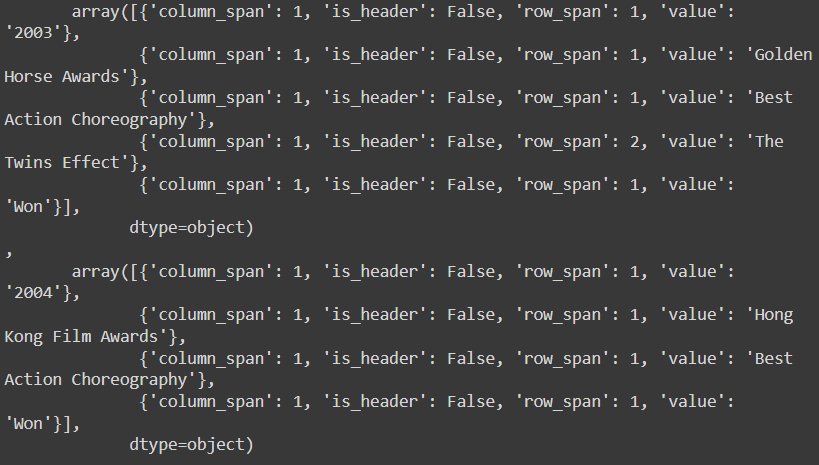

##**Processing Validation set tables**

First we will focus solely on one table.

In [ ]:
# Dictionary to store max number of cells per row for each table
max_cells_per_row_dict = {}

#for validation subset
for i, table in enumerate(val_df['table']):
    max_cells_per_row = get_max_cells_per_row(table)
    max_cells_per_row_dict[i] = max_cells_per_row

In [ ]:
# a list to store True/False for each table
tables_with_mismatched_rows = [has_mismatched_rows(table) for table in val_df['table']]

# Count the number of tables with mismatched rows
count_of_tables_with_mismatched_rows = sum(tables_with_mismatched_rows)

print(f"Number of tables with mismatched row length: {count_of_tables_with_mismatched_rows}")


Number of tables with mismatched row length: 6554


In [ ]:
my_table = val_df['table'][338]
mismatched_count = count_mismatched_rows(my_table)
print(f"Number of rows with mismatched cell and header counts: {mismatched_count}")

Number of rows with mismatched cell and header counts: 27


Let's try to fill in the cells that are missing in table 338 of the validation set.

In [ ]:
import pandas as pd
import copy

data=val_df['table'][338]
max_cells=max_cells_per_row_dict[338]
val_max_rs=get_max_rs_of_all_tables(val_df)

# Making a dict out of cell values and row span
organized_data = {}
for i in range(len(data)):
    for j in range(len(data[i])):
        cell_values = list(data[i][j].values())
        key = i
        value = cell_values[-1]  # Taking the values
        value2 = cell_values[-2]  # Taking the row span
        value3=cell_values[0] #taking the column span

        if key not in organized_data:
            organized_data[key] = [(value2, value, value3)]
        else:
            organized_data[key].append((value2, value, value3))

#adding missing dicts according to column span
result_dict = {}
for key, tuples_list in organized_data.items():
    repeated_tuples = []
    for tpl in tuples_list:
        rs, value, cs = tpl
        repeated_tuples.extend([(rs, value, cs)] * cs)
    result_dict[key] = repeated_tuples

#adding missing dicts according to row span
for j in tqdm(range(max_cells)):
  for i in range(len(result_dict)):
    if i in result_dict and j < len(result_dict[i]):
      value=result_dict[i][j]
      for rs in range(2,val_max_rs[270]+1):
        if value[0] == rs:
          tuple1=(1,value[1],1)
          for k in range(1,rs):
            if i+k in range(len(result_dict)):
              result_dict[i+k].insert(j,tuple1)


# Count the number of tuples per key
tuple_counts = {key: len(values) for key, values in result_dict.items()}

# Find the maximum count
max_count = max(tuple_counts.values())

# Add ("", "", "") tuple where the count is not the same across keys
for key in result_dict.keys():
    current_count = tuple_counts.get(key, 0)
    if current_count < max_count:
        diff = max_count - current_count
        result_dict[key].extend([("", "", "")] * diff)

new_result_dict = {key: [value[1] for value in values] for key, values in result_dict.items()}

pd.set_option("display.max_columns", None)
pd.DataFrame.from_dict(new_result_dict).T


100%|██████████| 9/9 [00:00<00:00, 31801.80it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,Regular season,Regular season,Regular season,Regular season,Regular season,Playoffs,Playoffs,Playoffs,Playoffs,Playoffs,,
1,Season,Team,League,,GP,G,A,Pts,PIM,,GP,G,A,Pts,PIM
2,2002–03,York-Simcoe Express,OMHA,14,5,13,18,27,—,—,—,—,—,,
3,2002–03,Aurora Tigers,OPJHL,34,12,13,25,55,—,—,—,—,—,,
4,2003–04,Windsor Spitfires,OHL,49,7,9,16,90,4,0,1,1,27,,
5,2004–05,Windsor Spitfires,OHL,61,21,52,73,179,11,4,5,9,49,,
6,2005–06,Windsor Spitfires,OHL,1,3,0,3,4,—,—,—,—,—,,
7,2005–06,Peterborough Petes,OHL,34,16,34,50,109,19,6,15,21,38,,
8,2006–07,Peterborough Petes,OHL,28,23,36,59,92,—,—,—,—,—,,
9,2006–07,Kitchener Rangers,OHL,17,12,21,33,32,9,8,14,22,15,,


Let's do this for all tables of the **validation subset**:

In [ ]:
%%time
val_max_rs=get_max_rs_of_all_tables(val_df)
table_indexes_to_process = range(len(val_df['table']))
processed_results_parallel = process_tables_parallel(val_df, table_indexes_to_process, max_cells_per_row_dict, val_max_rs)

CPU times: user 1min 16s, sys: 4.59 s, total: 1min 21s
Wall time: 1min 46s


In [ ]:
pd.DataFrame.from_dict(processed_results_parallel[323]).T

,0,1,2,3,4,5,6
0,№,Portrait,Name (Birth–Death),Term of Office,Term of Office,Political Party,Term
1,1,,Chen Chen-tsung 陳振宗 Chén Zhènzōng (?-1951),November 1950,October 1951,-,1
2,–,,Lu Ming 盧明 Lú Míng,October 1951,March 1952 As acting,-,1
3,2,,Wu Chin-yu 吳金玉 Wú Jīnyù,March 1952,June 1954,-,1
4,2,,Wu Chin-yu 吳金玉 Wú Jīnyù,June 1954,June 1957,-,
5,3,,Huang Tuo-jung 黃拓榮 Huáng Tuòróng,June 1957,2 June 1960,-,3
6,3,,Huang Tuo-jung 黃拓榮 Huáng Tuòróng,2 June 1960,2 June 1964,-,4
7,4,,Huang Shun-hsing 黃順興 Huáng Shùnxīng (1923–2002),2 June 1964,2 June 1968,Chinese Youth Party,5
8,5,,Hwang Ching-fong 黃鏡峰 Huáng Jìngfēng (1930–2012),2 June 1968,1 February 1973,-,6
9,5,,Hwang Ching-fong 黃鏡峰 Huáng Jìngfēng (1930–2012),1 February 1973,16 July 1976,-,7


Let's now check if the cell values indicated by the highlighted cells are present in the annotation.

In [ ]:
val_df.highlighted_cells[323]

array([array([22,  2], dtype=int32)], dtype=object)

In [ ]:
val_df.sentence_annotations[323]['final_sentence']

array(['Huang serverd as County Magistrate of Taitung.'], dtype=object)

Finally we save the result to use it later.

In [ ]:
import pickle

#saving the processed tables of validation set
file_path = 'processed_validation_set_row_col_span.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(processed_results_parallel, file)

##**Processing Training Set Tables**

In [ ]:
# Dictionary to store max number of cells per row for each table
max_cells_per_row_dict = {}
for i, table in enumerate(train_df['table']):
  max_cells_per_row = get_max_cells_per_row(table)
  max_cells_per_row_dict[i] = max_cells_per_row

In [ ]:
# a list to store True/False for each table
tables_with_mismatched_rows = [has_mismatched_rows(table) for table in train_df['table']]

# Count the number of tables with mismatched rows
count_of_tables_with_mismatched_rows = sum(tables_with_mismatched_rows)

print(f"Number of tables with mismatched row length: {count_of_tables_with_mismatched_rows}")


Number of tables with mismatched row length: 59082


In [ ]:
my_table = train_df['table'][5]
mismatched_count = count_mismatched_rows(my_table)
print(f"Number of rows with mismatched cell and header counts: {mismatched_count}")

Number of rows with mismatched cell and header counts: 6


Now we will do the same but for the **training set**.\
We will split the train dataframe into smaller dataframes due to the fact that the RAM is not enough. Then we will put everything into a single list.

In [ ]:
import math
subset_size = 1000
num_subsets = math.ceil(len(train_df) / subset_size)
train_df_list = [train_df[i * subset_size: (i + 1) * subset_size].reset_index(drop=True) for i in range(num_subsets)]

In [ ]:
import gc
import pickle
from tqdm import tqdm

processed_results_dict = {}  # Dictionary to store processed results

# getting the total number of subsets
num_subsets = len(train_df_list)

with tqdm(total=num_subsets, desc='Processing subsets:\n') as pbar:
    # Process each subset and save results
    for i, subset_of_train_df in enumerate(train_df_list):
        gc.collect()
        max_rs = get_max_rs_of_all_tables(subset_of_train_df)
        table_indexes_to_process = range(len(subset_of_train_df['table']))
        processed_results_parallel = process_tables_parallel(subset_of_train_df, table_indexes_to_process, max_cells_per_row_dict, max_rs)

        # Store processed results in the dictionary
        processed_results_dict[f'subset_{i+1}'] = processed_results_parallel
        pbar.update(1)

# Save the dictionary as a pickle file
with open('processed_results_dict.pkl', 'wb') as file:
    pickle.dump(processed_results_dict, file)


In [ ]:
train_df_processed_tables = []

# Append each list of dictionaries to the combined list
for sublist in processed_results_dict.keys():
    train_df_processed_tables.extend(processed_results_dict[sublist])

# Save the list as a pickle file
with open('train_df_processed_tables_row_col_span.pkl', 'wb') as file:
    pickle.dump(train_df_processed_tables, file)

In [ ]:
train_df.highlighted_cells[934]

array([array([5, 2], dtype=int32), array([19,  2], dtype=int32)],
      dtype=object)

In [ ]:
train_df.sentence_annotations[934]['final_sentence']

array(['The Mercedes-Benz 300 SL Roadster weighs 1,420 kg (3,131 lb) with 240 hp (179 kW) power.'],
      dtype=object)

##**Processing Test Set Tables**

Finally, we repeat the process for the **test set**:

In [ ]:
# Dictionary to store max number of cells per row for each table
max_cells_per_row_dict = {}
for i, table in enumerate(test_df['table']):
  max_cells_per_row = get_max_cells_per_row(table)
  max_cells_per_row_dict[i] = max_cells_per_row

In [ ]:
# a list to store True/False for each table
tables_with_mismatched_rows = [has_mismatched_rows(table) for table in test_df['table']]

# Count the number of tables with mismatched rows
count_of_tables_with_mismatched_rows = sum(tables_with_mismatched_rows)

print(f"Number of tables with mismatched row length: {count_of_tables_with_mismatched_rows}")

Number of tables with mismatched row length: 4267


In [ ]:
my_table = test_df['table'][22]
mismatched_count = count_mismatched_rows(my_table)
print(f"Number of rows with mismatched cell and header counts: {mismatched_count}")

Number of rows with mismatched cell and header counts: 3


In [ ]:
%%time
#for test subset
test_max_rs=get_max_rs_of_all_tables(test_df)
table_indexes_to_process = range(len(test_df['table']))
processed_results_parallel = process_tables_parallel(test_df, table_indexes_to_process, max_cells_per_row_dict, test_max_rs)

In [ ]:
import pandas as pd
pd.DataFrame(processed_results_parallel[689]).T

,0,1,2,3,4
0,RU Type,CBW20,CBW40,CBW80,CBW80+80 and CMW160
1,26-Tone RU,9,18,37,74
2,52-Tone RU,4,8,16,32
3,106-Tone RU,2,4,8,16
4,242-Tone RU,1,2,4,8
5,484-Tone RU,N/A,1,2,4
6,996-Tone RU,N/A,N/A,1,2
7,2x996 Tone RU,N/A,N/A,N/A,1


In [ ]:
test_df.highlighted_cells[689]

array([array([1, 0], dtype=int32), array([2, 0], dtype=int32),
       array([3, 0], dtype=int32), array([4, 0], dtype=int32),
       array([5, 0], dtype=int32), array([6, 0], dtype=int32),
       array([7, 0], dtype=int32)], dtype=object)

In [ ]:
test_df.sentence_annotations[689]['final_sentence']

array(['There are a few RUs defined: 26-tone RU, 52-tone RU, 106-tone RU, 242-tone RU (primary channel), 484-tone RU, 996-tone RU and 2x996-tone RU.',
       'There are a few RUs defined: 26-tone RU, 52-tone RU, 106-tone RU, 242-tone RU, 484-tone RU, 996-tone RU and 2x996-tone RU.',
       'The RUs defined are 26-tone RU, 52-tone RU, 106-tone RU, 242-tone RU, 484-tone RU, 996-tone RU and 2x996-tone RU.'],
      dtype=object)

In [ ]:
import pickle
# Save the list as a pickle file
with open('test_df_processed_tables.pkl', 'wb') as file:
    pickle.dump(processed_results_parallel, file)

#**EDA**

##Exploring Training Data

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108685 entries, 0 to 108684
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    108685 non-null  int32 
 1   table_page_title      108685 non-null  object
 2   table_webpage_url     108685 non-null  object
 3   table_section_title   108685 non-null  object
 4   table_section_text    108685 non-null  object
 5   table                 108685 non-null  object
 6   highlighted_cells     108685 non-null  object
 7   example_id            108685 non-null  object
 8   sentence_annotations  108685 non-null  object
 9   overlap_subset        108685 non-null  object
dtypes: int32(1), object(9)
memory usage: 7.9+ MB


 <font color='orange'>**Let's load the cleaned tables:** </font>

In [ ]:
#just the values
%%capture
!wget -O /content/processed_training_set_tables.pkl  https://www.dropbox.com/scl/fi/bw6gdwfrvyq52fxnw0bjk/train_df_processed_tables_all_list.pkl?rlkey=bi35y4zm45mhvq22gu9cew2qn&dl=0

In [ ]:
# values plus row span and column span
%%capture
!wget -O /content/processed_training_set_tables_col_row_span.pkl  https://www.dropbox.com/scl/fi/vaz0l5jwsn1o54k8ynxbl/train_df_processed_tables_row_col_span.pkl?rlkey=56fjv1myyb3q8v4fps5qyoi8f&dl=0

In [ ]:
import pickle

#file_path = '/content/processed_training_set_tables.pkl'
file_path = '/content/processed_training_set_tables_col_row_span.pkl'

# Load the dictionary from the pickle file
with open(file_path, 'rb') as file:
    processed_training_set = pickle.load(file)

In [ ]:
import pandas as pd
pd.DataFrame(processed_training_set[0]).T

,0,1,2,3,4,5,6
0,#,Run,Title,Chapters,Author,Director,Ibope Rating
1,59,"June 5, 2000— February 2, 2001",Laços de Família,209,Manoel Carlos,Ricardo Waddington,44.9
2,60,"February 5, 2001— September 28, 2001",Porto dos Milagres,203,Aguinaldo Silva Ricardo Linhares,Marcos Paulo Simões,44.6
3,61,"October 1, 2001— June 14, 2002",O Clone,221,Glória Perez,Jayme Monjardim,47.0
4,62,"June 17, 2002— February 14, 2003",Esperança,209,Benedito Ruy Barbosa,Luiz Fernando,37.7
5,63,"February 17, 2003— October 10, 2003",Mulheres Apaixonadas,203,Manoel Carlos,Ricardo Waddington,46.6
6,64,"October 13, 2003— June 25, 2004",Celebridade,221,Gilberto Braga,Dennis Carvalho,46.0
7,65,"June 28, 2004— March 11, 2005",Senhora do Destino,221,Aguinaldo Silva,Wolf Maya,50.4
8,66,"March 14, 2005— November 4, 2005",América,203,Glória Perez,Jayme Monjardim Marcos Schechtman,49.4
9,67,"November 7, 2005— July 7, 2006",Belíssima,209,Sílvio de Abreu,Denise Saraceni,48.5


In [ ]:
#Creating a new column that contains only the final sentence text
train_df['final_sentence'] = train_df['sentence_annotations'].apply(lambda arr: arr['final_sentence'][0] if len(arr) > 0 else "")

In [ ]:
#Dropping unnecessary columns
del train_df['example_id'],train_df['id'],train_df['sentence_annotations'],train_df['overlap_subset']#,train_df['table_webpage_url']

In [ ]:
#adding the peocessed table to the training dataframe
train_df['processed_table']=processed_training_set

In [ ]:
train_df['final_sentence'][0]

'A Favorita is the telenovela aired in the 9 pm timeslot.'

The data that we will use are:
* the **processed** tables
* the **original** tables
* the table page title
* the table section title
* the table section text
* the highlighted cells
* the final sentence



In [ ]:
train_df

,table_page_title,table_section_title,table_section_text,table,highlighted_cells,final_sentence,processed_table
0,List of 8/9 PM telenovelas of Rede Globo,2000s,,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[13, 2]]",A Favorita is the telenovela aired in the 9 pm...,"{0: ['#', 'Run', 'Title', 'Chapters', 'Author'..."
1,List of Chicago Bears first-round draft picks,Player selections,,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[100, 0], [100, 2], [100, 3], [100, 4]]",The Chicago Bears recent first round selection...,"{0: ['Year', 'Pick', 'Player name', 'Position'..."
2,Brian Ebersole,Mixed martial arts record,,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[9, 2], [9, 4]]",Ebersole made his UFC debut against Chris Lytl...,"{0: ['Res.', 'Record', 'Opponent', 'Method', '..."
3,78th United States Congress,Senate,,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[1, 1], [1, 2], [1, 3], [1, 4], [8, 1], [8, 3...",William Warren Barbour (R) served as Senate un...,"{0: ['State (class)', 'Vacator', 'Reason for c..."
4,Elagabalus,External links,Media related to Elagabalus at Wikimedia Commo...,"[[{'column_span': 3, 'is_header': False, 'row_...","[[0, 0], [2, 1]]",Elagabalus (204 – 11 March 222) was Roman empe...,{0: ['Elagabalus Severan dynastyBorn: c.204 Di...
...,...,...,...,...,...,...,...
108680,Ali Karimi,International goals,,"[[{'column_span': 7, 'is_header': True, 'row_s...","[[37, 1], [37, 3], [37, 4], [37, 5], [37, 6]]","On 10 June 2009, Karimi scored International g...","{0: ['Ali Karimi international goals', 'Ali Ka..."
108681,Kasagami-Kurohae Station,Passenger statistics,,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[4, 0], [4, 1]]","In the fiscal year 2010, the station was used ...","{0: ['Fiscal year', 'Daily average'], 1: ['200..."
108682,Stade de France,UEFA Euro 2016 matches,,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[7, 2], [7, 4], [7, 5]]",The Stade de France was used for the UEFA Euro...,"{0: ['Date', 'Time (CET)', 'Team #1', 'Res.', ..."
108683,Yellow Book of Lecan,Contents,The numbering for the texts given below is bot...,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[30, 2], [38, 0], [39, 0]]","The Yellow Book of Lecan is written on vellum,...","{0: ['columns', 'page', 'text'], 1: ['1–2', '4..."


In [ ]:
train_df['table_section_text'].value_counts().head(10)

                                                                                        76883
Source:                                                                                   638
Source                                                                                     94
* Season still in progress.                                                                70
Note: At least 7.0 magnitude                                                               66
Sources:                                                                                   64
(key) (Races in bold indicate pole position) (Races in italics indicate fastest lap)       58
All information taken from IAAF profile.                                                   52
Table key                                                                                  46
Win Draw Loss                                                                              43
Name: table_section_text, dtype: int64

Text(0.5, 1.0, 'Top 20 Table Section Titles of Training Set')

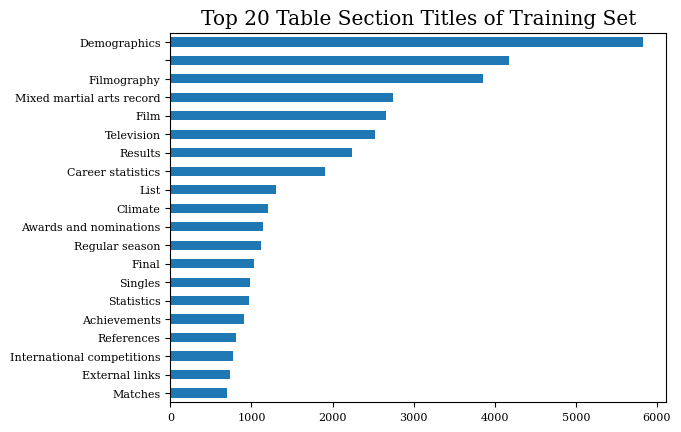

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8

train_df['table_section_title'].value_counts().head(20).sort_values(ascending=True).plot(kind='barh')
plt.title('Top 20 Table Section Titles of Training Set')

Text(0.5, 1.0, 'Top 20 Table Page Titles of Training Set')

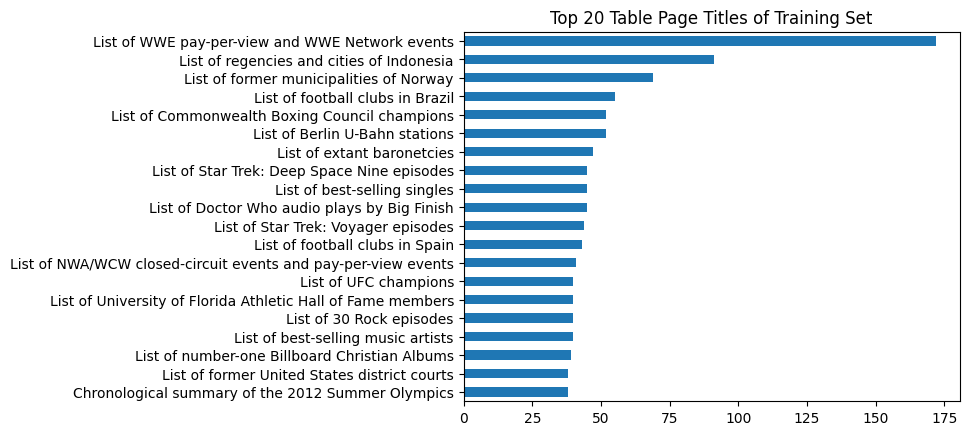

In [ ]:
train_df['table_page_title'].value_counts().head(20).sort_values(ascending=True).plot(kind='barh')
plt.title('Top 20 Table Page Titles of Training Set')

In [ ]:
#checking for html tags
print("Training Set:\n")
for i in train_df.columns:
  html_tags_scan(i)

Training Set:

table_page_title : The number of records containing HTML tags is 0
table_section_title : The number of records containing HTML tags is 0
table_section_text : The number of records containing HTML tags is 0
highlighted_cells : The number of records containing HTML tags is 0
final_sentence : The number of records containing HTML tags is 0


In [ ]:
text_length_stats(train_df,"Training")

Text Length Stats-Training Set:

Final Sentence:
The average text length is 86 characters.
The standard deviation of text length is 35 characters.
The minimum text length is 1 characters.
The maximum text length is 343 characters.

Table Page Title:
The average text length is 24 characters.
The standard deviation of text length is 13 characters.
The minimum text length is 1 characters.
The maximum text length is 102 characters.

Table Section Title:
The average text length is 14 characters.
The standard deviation of text length is 9 characters.
The minimum text length is 0 characters.
The maximum text length is 111 characters.

Table Section Text:
The average text length is 39 characters.
The standard deviation of text length is 88 characters.
The minimum text length is 0 characters.
The maximum text length is 4495 characters.


Now we will check the frequency of row and column appearances.

In [ ]:
num_row_col_train=get_num_row_col(train_df)

100%|██████████| 108685/108685 [02:22<00:00, 764.16it/s]


Creating a dictionary that has the number of rows as key and the frequency as value.

In [ ]:
from collections import defaultdict

row_frequency_train = defaultdict(int)
for key, values_list in num_row_col_train.items():
  first_element = values_list[0]
  row_frequency_train[first_element] += 1
row_frequency_train=sorted(row_frequency_train.items(), key=lambda x:x[1],reverse=True)

print("10 most frequent number of rows:\n")
for i in range(len(row_frequency_train[0:10])):
  print(f"Number of rows: {row_frequency_train[i][0]}, Frequency: {row_frequency_train[i][1]}")

10 most frequent number of rows:

Number of rows: 2, Frequency: 6120
Number of rows: 6, Frequency: 4400
Number of rows: 7, Frequency: 4150
Number of rows: 3, Frequency: 4075
Number of rows: 9, Frequency: 3921
Number of rows: 5, Frequency: 3910
Number of rows: 11, Frequency: 3736
Number of rows: 8, Frequency: 3415
Number of rows: 10, Frequency: 3377
Number of rows: 13, Frequency: 3270


###**Sampling**

Since the training set is very extensive we will take a sample of it to reduce the time needed to perform all necessary tasks. By using stratified sampling we ensure that the percentage of tables per subject matches the original training subset.

In [ ]:
stratified_sample_train= train_df.groupby('table_section_title').apply(lambda x: x.sample(frac=0.25,random_state=42))
stratified_sample_train=stratified_sample_train.apply(lambda x: x.reset_index(drop=True))

In [ ]:
stratified_sample_train

,table_page_title,table_webpage_url,table_section_title,table_section_text,table,highlighted_cells,final_sentence,processed_table
0,List of Commanders of the Turkish Land Forces,http://en.wikipedia.org/wiki/List_of_Commander...,,This list includes Commanders of the Turkish L...,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[33, 1], [33, 3], [33, 4]]",Doğan Güreş was a Commander of the Turkish Arm...,"{0: [(1, 'No.', 1), (1, 'Commander', 1), (1, '..."
1,List of Presidents of the Chamber of Deputies ...,http://en.wikipedia.org/wiki/List_of_President...,,List of Presidents of the Chamber of Deputies ...,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[96, 0], [96, 1]]","In February 1985, Antonio Marchesano was Presi...","{0: [(1, 'Name', 1), (1, 'Entered office', 1),..."
2,List of districts of Istanbul,http://en.wikipedia.org/wiki/List_of_districts...,,This is a list of districts of Istanbul in Tur...,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[14, 0]]",Büyükçekmece is a district of Istanbul.,"{0: [(1, 'District', 1), (1, 'Population (2018..."
3,List of largest California cities by population,http://en.wikipedia.org/wiki/List_of_largest_C...,,This is a list of the 100 largest cities in th...,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[9, 0], [9, 1]]",Bakersfield's population makes it the 9th-most...,"{0: [(1, '2015 Rank', 1), (1, 'City', 1), (1, ..."
4,List of Irish state funerals,http://en.wikipedia.org/wiki/List_of_Irish_sta...,,State funerals (Irish: Tórraimh stáit) in Irel...,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[22, 1], [22, 2], [22, 4]]",President Erskine Childers died in office in 1...,"{0: [(1, 'Date', 1), (1, 'Recipient', 1), (1, ..."
...,...,...,...,...,...,...,...,...
23645,List of kings of Connacht,http://en.wikipedia.org/wiki/List_of_kings_of_...,"Ó Conchubhair Donn, 1368–1474",,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[5, 0], [5, 1], [5, 3]]",Fedlim Geancach Ó Conchobair was the son of To...,"{0: [(1, 'Name', 1), (1, 'Reign', 1), (1, 'Cla..."
23646,List of Belgrade neighbourhoods and suburbs,http://en.wikipedia.org/wiki/List_of_Belgrade_...,Čukarica,Ada Ciganlija Azbestno Naselje Banovo Brdo Bel...,"[[{'column_span': 1, 'is_header': False, 'row_...","[[0, 1]]",Čukarička padina is a neighborhood of Belgrade.,"{0: [(1, 'Ada Ciganlija Azbestno Naselje Banov..."
23647,List of Belgrade neighbourhoods and suburbs,http://en.wikipedia.org/wiki/List_of_Belgrade_...,Čukarica,Ada Ciganlija Azbestno Naselje Banovo Brdo Bel...,"[[{'column_span': 1, 'is_header': False, 'row_...","[[0, 0]]",Careva Ćuprija is a neighborhood of Belgrade.,"{0: [(1, 'Ada Ciganlija Azbestno Naselje Banov..."
23648,Yelena Isinbayeva,http://en.wikipedia.org/wiki/Yelena_Isinbayeva,Αchievements,,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[1, 0], [2, 0], [2, 1]]",Yelena Isinbayeva appeared in 1998 World Junio...,"{0: [(1, 'Year', 1), (1, 'Competition', 1), (1..."


(0.0, 1600.0)

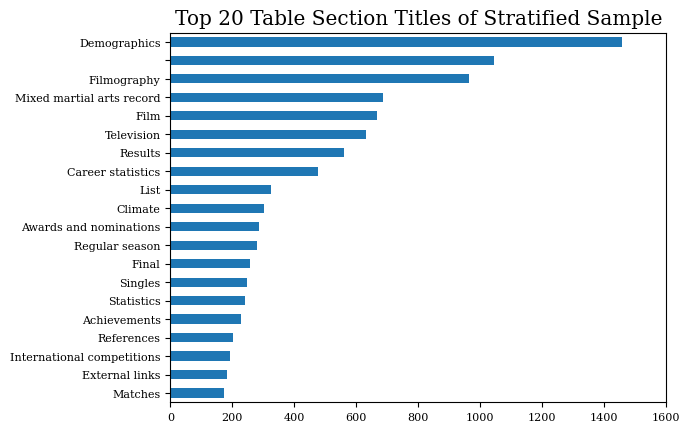

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

#Customize
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8

stratified_sample_train['table_section_title'].value_counts()[0:20].sort_values(ascending=True).plot(kind='barh')
plt.title('Top 20 Table Section Titles of Stratified Sample')
plt.xlim(right=1600)

In [ ]:
num_row_col_train_sample=get_num_row_col(stratified_sample_train)

100%|██████████| 23650/23650 [00:32<00:00, 738.72it/s]


In [ ]:
from collections import defaultdict

row_frequency_train_sample = defaultdict(int)
for key, values_list in num_row_col_train_sample.items():
  first_element = values_list[0]
  row_frequency_train_sample[first_element] += 1
row_frequency_train_sample=sorted(row_frequency_train_sample.items(), key=lambda x:x[1],reverse=True)


In [ ]:
print("10 most frequent number of rows of Stratified Sample:\n")
for i in range(len(row_frequency_train_sample[0:10])):
  print(f"Number of rows: {row_frequency_train_sample[i][0]}, Frequency: {row_frequency_train_sample[i][1]}")

10 most frequent number of rows of Stratified Sample:

Number of rows: 2, Frequency: 1309
Number of rows: 7, Frequency: 906
Number of rows: 6, Frequency: 888
Number of rows: 9, Frequency: 841
Number of rows: 3, Frequency: 833
Number of rows: 11, Frequency: 801
Number of rows: 5, Frequency: 788
Number of rows: 8, Frequency: 723
Number of rows: 13, Frequency: 708
Number of rows: 10, Frequency: 703


##Exploring the Validation Set


In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12076 entries, 0 to 12075
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    12076 non-null  int32 
 1   table_page_title      12076 non-null  object
 2   table_webpage_url     12076 non-null  object
 3   table_section_title   12076 non-null  object
 4   table_section_text    12076 non-null  object
 5   table                 12076 non-null  object
 6   highlighted_cells     12076 non-null  object
 7   example_id            12076 non-null  object
 8   sentence_annotations  12076 non-null  object
 9   overlap_subset        12076 non-null  object
dtypes: int32(1), object(9)
memory usage: 896.4+ KB


<font color='orange'>**Let's load the cleaned tables:** </font>

In [ ]:
%%capture
!wget -O /content/processed_validation_set_tables.pkl  https://www.dropbox.com/scl/fi/16v2utyccmhuhnvw4iabi/processed_validation_set.pkl?rlkey=e63hhx34ig5seyp038dg27tjo&dl=0

In [ ]:
#with row col span
%%capture
!wget -O /content/processed_validation_set_tables.pkl  https://www.dropbox.com/scl/fi/mvh54ea1wrw71gbqb9xr8/processed_validation_set_row_col_span.pkl?rlkey=kk4b5d6tr4l71sk653xyi108a&dl=0

In [ ]:
import pickle
file_path = '/content/processed_validation_set_tables.pkl'

# Load the dictionary from the pickle file
with open(file_path, 'rb') as file:
    val_df_dict = pickle.load(file)

In [ ]:
pd.DataFrame(val_df_dict[0]).T

,0,1,2,3
0,Session,Senate,Assembly,Assembly
1,1974–1975,John Skevin (D),Edward H. Hynes (D),Paul Contillo (D)
2,1976–1977,John Skevin (D),Robert Burns (D),Paul Contillo (D)
3,1978–1979,John Skevin (D),Robert Burns (D),Paul Contillo (D)
4,1980–1981,John Skevin (D),John B. Paolella (R),Louis F. Kosco (R)
5,1982–1983,John B. Paolella (R),Pat Schuber (R),Louis F. Kosco (R)
6,1984–1985,Paul Contillo (D),Pat Schuber (R),Louis F. Kosco (R)
7,1986–1987,Paul Contillo (D),Pat Schuber (R),Louis F. Kosco (R)
8,1988–1989,Paul Contillo (D),Pat Schuber (R),Patrick J. Roma (R)
9,1990–1991,Paul Contillo (D),Pat Schuber (R),Patrick J. Roma (R)


In [ ]:
#Creating a new column that contains only the final sentence text
val_df['final_sentence'] = val_df['sentence_annotations'].apply(lambda arr: arr['final_sentence'][0] if len(arr) > 0 else "")

In [ ]:
#adding the processed table to the validation dataframe
val_df['processed_table']=val_df_dict

In [ ]:
#Dropping unnecessary columns
del val_df['example_id'],val_df['id'],val_df['sentence_annotations'],val_df['overlap_subset']

The data that we will use are:
* the **processed** tables
* the tabble page title
* the table section title
* the table section text
* the highlighted cells
* the final sentence

In [ ]:
val_df.head(5)

,table_page_title,table_section_title,table_section_text,highlighted_cells,final_sentence
0,38th Legislative District (New Jersey),Election history,"In October 2015, Anthony Cappola left the race...","[[27, 0], [28, 0], [28, 1], [28, 2]]",The 38th Legislative District is represented f...
1,2015–16 Mohun Bagan A.C. season,AFC Cup,,"[[0, 3], [1, 3]]","In the 116th minute of the match, it was Afiq ..."
2,Ealhmund of Kent,External links,Ealhmund 4 at Prosopography of Anglo-Saxon Eng...,"[[1, 1]]",784 was the Ealhmund's reign in Kent.
3,Ding Jiali,Film,,"[[1, 0], [1, 1], [1, 3]]","In 1986, Ding appeared as Xiaobaixie in the fi..."
4,Angra Toldo,Population history,,"[[4, 0], [4, 1]]","In the 2012 census, Toldo's population was 433."


In [ ]:
#checking for html tags
print("Validation Set:\n")
for i in val_df.columns:
  html_tags_scan(i)

Validation Set:

table_page_title : The number of records containing HTML tags is 0
table_section_title : The number of records containing HTML tags is 0
table_section_text : The number of records containing HTML tags is 0
highlighted_cells : The number of records containing HTML tags is 0
final_sentence : The number of records containing HTML tags is 0


Text(0.5, 1.0, 'Top 20 Table Section Titles of validation Set')

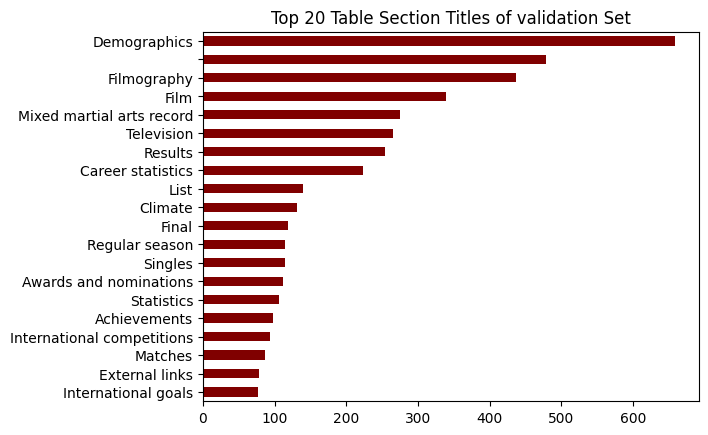

In [ ]:
import matplotlib.pyplot as plt

val_df['table_section_title'].value_counts().head(20).sort_values(ascending=True).plot(kind='barh',color='maroon')
plt.title('Top 20 Table Section Titles of validation Set')

Text(0.5, 1.0, 'Top 20 Table Page Titles of validation Set')

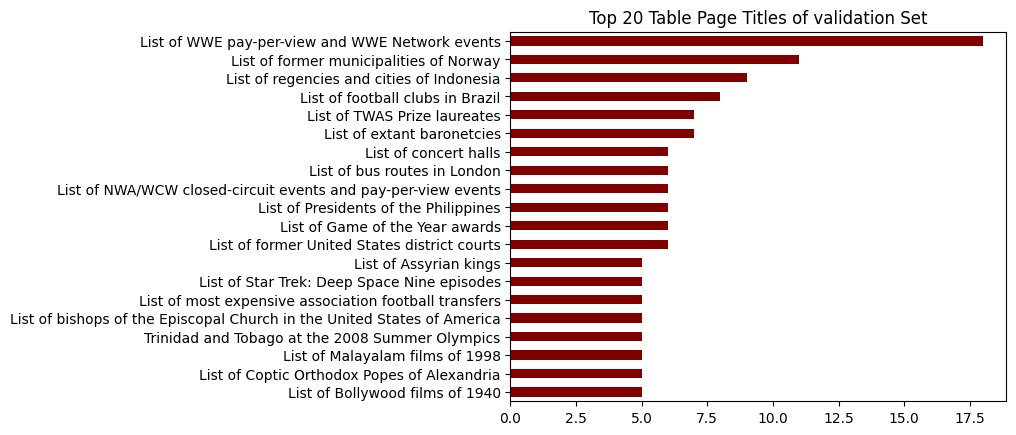

In [ ]:
val_df['table_page_title'].value_counts().head(20).sort_values(ascending=True).plot(kind='barh',color='maroon')
plt.title('Top 20 Table Page Titles of validation Set')

In [ ]:
text_length_stats(val_df,"Validation")

Text Length Stats-Validation Set:

Final Sentence:
The average text length is 86 characters.
The standard deviation of text length is 35 characters.
The minimum text length is 17 characters.
The maximum text length is 302 characters.

Table Page Title:
The average text length is 24 characters.
The standard deviation of text length is 14 characters.
The minimum text length is 2 characters.
The maximum text length is 98 characters.

Table Section Title:
The average text length is 14 characters.
The standard deviation of text length is 9 characters.
The minimum text length is 0 characters.
The maximum text length is 111 characters.

Table Section Text:
The average text length is 39 characters.
The standard deviation of text length is 83 characters.
The minimum text length is 0 characters.
The maximum text length is 2568 characters.


Now we will check the frequency of row and column appearances.

In [ ]:
#extracting the number of rows and columns
num_row_col_val={}
for t in tqdm(range(len(val_df))):
  num_rows, num_columns = pd.DataFrame(val_df['processed_table'][t]).T.shape
  num_row_col_val[t]=[num_rows, num_columns]


100%|██████████| 12076/12076 [00:17<00:00, 676.01it/s]


Creating a dictionary that has the number of rows as key and the frequency as value.

In [ ]:
from collections import defaultdict

row_frequency_val = defaultdict(int)
for key, values_list in num_row_col_val.items():
  first_element = values_list[0]
  row_frequency_val[first_element] += 1
row_frequency_val=sorted(row_frequency_val.items(), key=lambda x:x[1],reverse=True)


In [ ]:
print("10 most frequent number of rows:\n")
for i in range(len(row_frequency_val[0:10])):
  print(f"Number of rows: {row_frequency_val[i][0]}, Frequency: {row_frequency_val[i][1]}")

10 most frequent number of rows:

Number of rows: 2, Frequency: 669
Number of rows: 6, Frequency: 516
Number of rows: 9, Frequency: 450
Number of rows: 7, Frequency: 450
Number of rows: 3, Frequency: 450
Number of rows: 5, Frequency: 405
Number of rows: 11, Frequency: 402
Number of rows: 10, Frequency: 402
Number of rows: 8, Frequency: 384
Number of rows: 4, Frequency: 360


##Exploring the Test Set



In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7700 entries, 0 to 7699
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    7700 non-null   int32 
 1   table_page_title      7700 non-null   object
 2   table_webpage_url     7700 non-null   object
 3   table_section_title   7700 non-null   object
 4   table_section_text    7700 non-null   object
 5   table                 7700 non-null   object
 6   highlighted_cells     7700 non-null   object
 7   example_id            7700 non-null   object
 8   sentence_annotations  7700 non-null   object
 9   overlap_subset        7700 non-null   object
dtypes: int32(1), object(9)
memory usage: 571.6+ KB


<font color='orange'>**Let's load the cleaned tables:** </font>

In [ ]:
%%capture
!wget -O /content/processed_test_set_tables.pkl  https://www.dropbox.com/scl/fi/7s0piugx16jo56atukj7v/test_df_processed_tables.pkl?rlkey=yrbdv5neu626cfexajvgtrdq2&dl=0

In [ ]:
#row col span included
%%capture
!wget -O /content/processed_test_set_tables.pkl https://www.dropbox.com/scl/fi/tifjuz5qe9a7xof97l7ve/test_df_processed_tables_row_col_span.pkl?rlkey=8cgmvk4vvbbs178u51ttbt14o&dl=0

In [ ]:
import pickle

file_path = '/content/processed_test_set_tables.pkl'

# Load the dictionary from the pickle file
with open(file_path, 'rb') as file:
    test_df_dict = pickle.load(file)

In [ ]:
test_df['table_webpage_url'].iloc[26]

'http://en.wikipedia.org/wiki/Arrow_Point,_Missouri'

In [ ]:
import pandas as pd
pd.DataFrame(test_df_dict[26]).T

,0,1,2,3
0,"(1, Historical population, 4)","(1, Historical population, 4)","(1, Historical population, 4)","(1, Historical population, 4)"
1,"(1, Census, 1)","(1, Pop., 1)","(1, , 1)","(1, %±, 1)"
2,"(1, 2000, 1)","(1, 133, 1)","(1, , 1)","(1, —, 1)"
3,"(1, 2010, 1)","(1, 86, 1)","(1, , 1)","(1, −35.3%, 1)"
4,"(1, Est. 2017, 1)","(1, 86, 1)","(1, , 1)","(1, 0.0%, 1)"
5,"(1, U.S. Decennial Census, 4)","(1, U.S. Decennial Census, 4)","(1, U.S. Decennial Census, 4)","(1, U.S. Decennial Census, 4)"


In [ ]:
test_df.highlighted_cells[638]

array([array([44,  0], dtype=int32), array([44,  2], dtype=int32),
       array([44,  3], dtype=int32), array([44,  5], dtype=int32)],
      dtype=object)

In [ ]:
test_df.sentence_annotations[638]['final_sentence']

array(['George VIII (გიორგი VIII, 1417–1476) was the last King of Georgia from 1446 to 1465.',
       'George VIII (1417–1476) was the last king of the united Georgia from 1446 to 1465.',
       'George VIII (1417–1476), was the last king of the united Georgia from 1446 to 1465.'],
      dtype=object)

In [ ]:
#Creating a new column that contains only the final sentence text
test_df['final_sentence'] = test_df['sentence_annotations'].apply(lambda arr: arr['final_sentence'][0] if len(arr) > 0 else "")

In [ ]:
#adding the processed table to the test dataframe
test_df['processed_table']=test_df_dict

In [ ]:
del test_df['example_id'],test_df['id'], test_df['sentence_annotations'],test_df['overlap_subset']

The data that we will use are:
* the **processed** tables
* the tabble page title
* the table section title
* the table section text
* the highlighted cells
* the final sentence

In [ ]:
#checking for html tags
print("Test Set:\n")
for i in test_df.columns:
  html_tags_scan(i)

Test Set:

table_page_title : The number of records containing HTML tags is 0
table_section_title : The number of records containing HTML tags is 0
table_section_text : The number of records containing HTML tags is 0
highlighted_cells : The number of records containing HTML tags is 0
final_sentence : The number of records containing HTML tags is 0


Text(0.5, 1.0, 'Top 20 Table Section Titles of Test Set')

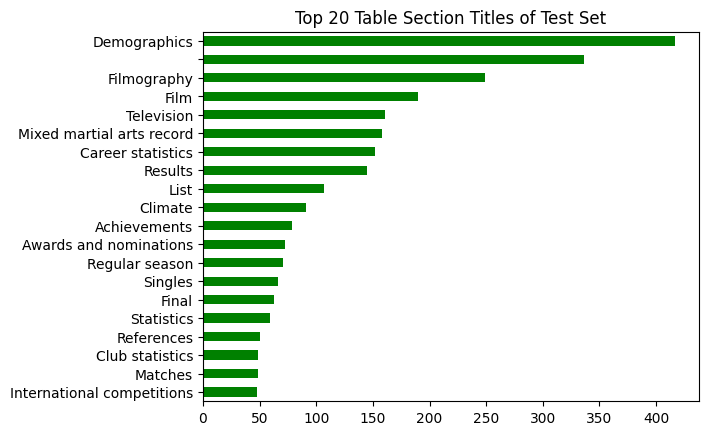

In [ ]:
import matplotlib.pyplot as plt

test_df['table_section_title'].value_counts().head(20).sort_values(ascending=True).plot(kind='barh',color='green')
plt.title('Top 20 Table Section Titles of Test Set')

Text(0.5, 1.0, 'Top 20 Table Page Titles of Test Set')

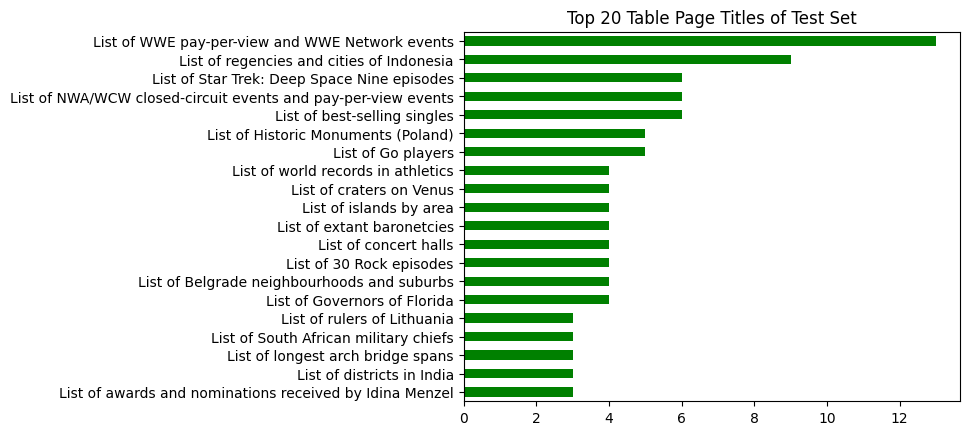

In [ ]:
test_df['table_page_title'].value_counts().head(20).sort_values(ascending=True).plot(kind='barh',color='green')
plt.title('Top 20 Table Page Titles of Test Set')

In [ ]:
text_length_stats(test_df,"Test")

Text Length Stats-Test Set:

Final Sentence:
The average text length is 86 characters.
The standard deviation of text length is 35 characters.
The minimum text length is 16 characters.
The maximum text length is 291 characters.

Table Page Title:
The average text length is 24 characters.
The standard deviation of text length is 14 characters.
The minimum text length is 3 characters.
The maximum text length is 108 characters.

Table Section Title:
The average text length is 14 characters.
The standard deviation of text length is 10 characters.
The minimum text length is 0 characters.
The maximum text length is 133 characters.

Table Section Text:
The average text length is 39 characters.
The standard deviation of text length is 83 characters.
The minimum text length is 0 characters.
The maximum text length is 1920 characters.


Now we will check the frequency of row and column appearances.

In [ ]:
#extracting the number of rows and columns
num_row_col_test={}
for t in tqdm(range(len(test_df))):
  num_rows, num_columns = pd.DataFrame(test_df['processed_table'][t]).T.shape
  num_row_col_test[t]=[num_rows, num_columns]


100%|██████████| 7700/7700 [00:09<00:00, 791.53it/s]


Creating a dictionary that has the number of rows as key and the frequency as value.

In [ ]:
from collections import defaultdict

row_frequency_test = defaultdict(int)
for key, values_list in num_row_col_test.items():
  first_element = values_list[0]
  row_frequency_test[first_element] += 1
row_frequency_test=sorted(row_frequency_test.items(), key=lambda x:x[1],reverse=True)


In [ ]:
print("10 most frequent number of rows:\n")
for i in range(len(row_frequency_test[0:10])):
  print(f"Number of rows: {row_frequency_test[i][0]}, Frequency: {row_frequency_test[i][1]}")

10 most frequent number of rows:

Number of rows: 2, Frequency: 399
Number of rows: 7, Frequency: 311
Number of rows: 6, Frequency: 301
Number of rows: 3, Frequency: 298
Number of rows: 5, Frequency: 291
Number of rows: 11, Frequency: 267
Number of rows: 9, Frequency: 261
Number of rows: 8, Frequency: 254
Number of rows: 13, Frequency: 238
Number of rows: 10, Frequency: 236


#**Creating Table Templates**

In order to feed the data to the chosen models we need to convert them into a text format.

We will create a text template for each table. Each template is comprised by the table converted into text format, the table_page_title, the	table_section_title, the table_section_text	and the highlighted text (text indicated by highlighted cells).



##**Test Set:**

In [ ]:
from tqdm import tqdm
table_to_text_test={}
for t in tqdm(range(len(test_df['processed_table']))):
  if not test_df['processed_table'][t] is None:
    table_to_text_test[t]=text_from_table(test_df,t)
  else:
    table_to_text_test[t]= test_df['processed_table'][t]

100%|██████████| 7700/7700 [1:14:53<00:00,  1.71it/s]


In [ ]:
import pickle
# Save the list as a pickle file
with open('test_df_table_to_text.pkl', 'wb') as file:
    pickle.dump(table_to_text_test, file)

In [ ]:
table_to_text_test[876]

'Rank is 1, Home team is Atlético de Kolkata, Score is 3–0, Away team is Mumbai City, Attendance is 65,000, Date is 12 October 2014, Stadium is Salt Lake Stadium. Rank is 2, Home team is Kerala Blasters, Score is 0–1, Away team is Chennaiyin, Attendance is 61,323, Date is 30 November 2014, Stadium is Jawaharlal Nehru Stadium. Rank is 3, Home team is Kerala Blasters, Score is 3–0, Away team is Chennaiyin, Attendance is 60,900, Date is 13 December 2014, Stadium is Jawaharlal Nehru Stadium. Rank is 4, Home team is Kerala Blasters, Score is 2–1, Away team is Atlético de Kolkata, Attendance is 57,296, Date is 21 November 2014, Stadium is Jawaharlal Nehru Stadium. Rank is 5, Home team is Atlético de Kolkata, Score is 1–1, Away team is Delhi Dynamos, Attendance is 55,793, Date is 19 October 2014, Stadium is Salt Lake Stadium. Rank is 6, Home team is Atlético de Kolkata, Score is 0–0, Away team is Goa, Attendance is 53,173, Date is 14 December 2014, Stadium is Salt Lake Stadium. Rank is 7, Hom

 <font color='orange'>**Loading the test set text templates from dropbox:** </font>

In [ ]:
# values plus row span and column span
%%capture
!wget -O /content/test_df_table_to_text.pkl  https://www.dropbox.com/scl/fi/h2rvlkjjxzhzhqwla1bz9/test_df_table_to_text-1.pkl?rlkey=2t38ce4mhmj1c19lu2cjav9aa&dl=0

In [ ]:
import pickle

file_path = '/content/test_df_table_to_text.pkl'

# Load the dictionary from the pickle file
with open(file_path, 'rb') as file:
    table_to_text_test= pickle.load(file)

Now we will clean it from elements that may confuse the model like html tags.

In [ ]:
from tqdm import tqdm

cleaned_test_templates = {}
for k in tqdm(list(table_to_text_test.keys())):
    if table_to_text_test[k] is not None and table_to_text_test[k] != "":
        cleaned_test_templates[k] = text_cleaner(table_to_text_test[k])
    else:
        cleaned_test_templates[k] = table_to_text_test[k]


100%|██████████| 7700/7700 [00:15<00:00, 490.76it/s]


In [ ]:
cleaned_test_templates[876]

'Rank is 1, Home team is Atlético de Kolkata, Score is 30, Away team is Mumbai City, Attendance is 65,000, Date is 12 October 2014, Stadium is Salt Lake Stadium. Rank is 2, Home team is Kerala Blasters, Score is 01, Away team is Chennaiyin, Attendance is 61,323, Date is 30 November 2014, Stadium is Jawaharlal Nehru Stadium. Rank is 3, Home team is Kerala Blasters, Score is 30, Away team is Chennaiyin, Attendance is 60,900, Date is 13 December 2014, Stadium is Jawaharlal Nehru Stadium. Rank is 4, Home team is Kerala Blasters, Score is 21, Away team is Atlético de Kolkata, Attendance is 57,296, Date is 21 November 2014, Stadium is Jawaharlal Nehru Stadium. Rank is 5, Home team is Atlético de Kolkata, Score is 11, Away team is Delhi Dynamos, Attendance is 55,793, Date is 19 October 2014, Stadium is Salt Lake Stadium. Rank is 6, Home team is Atlético de Kolkata, Score is 00, Away team is Goa, Attendance is 53,173, Date is 14 December 2014, Stadium is Salt Lake Stadium. Rank is 7, Home team

Get the highlighted text and clean it:

In [ ]:
import pandas as pd
hc_text_test=get_text_from_hc(test_df)
hc_text_test_clean=clean_hc_text(hc_text_test)

Extracting the number of columns and rows of each table to pass the the structure information to the model:

In [ ]:
structure_test={}
for t in tqdm(range(len(test_df))):
  num_rows, num_columns = pd.DataFrame(test_df['processed_table'][t]).T.shape
  structure_test[t]=f"Table Structure: {num_rows} rows, {num_columns} columns."

100%|██████████| 7700/7700 [00:09<00:00, 788.45it/s]


In [ ]:
list(structure_test.values())[0:4]

['Table Structure: 13 rows, 8 columns.',
 'Table Structure: 11 rows, 4 columns.',
 'Table Structure: 12 rows, 16 columns.',
 'Table Structure: 8 rows, 5 columns.']

Combining the table converted to text with the metadata and the structure information:

In [ ]:
input_templates_test={}
for idx in tqdm(range(len(test_df))):
  page_title = test_df['table_page_title'][idx]
  section_title = test_df['table_section_title'][idx]
  section_text = test_df['table_section_text'][idx]
  table_text = cleaned_test_templates[idx]
  hc_text = hc_text_test_clean[idx]
  table_structure = structure_test[idx]
  input_templates_test[idx] = f"Table page title: {page_title}, Table section title: {section_title}, Table section text: {section_text}, Table converted to text: {table_text}, Focus on: {hc_text}, {table_structure}"
  input_templates_test[idx] = input_templates_test[idx].replace(".,", ",")


100%|██████████| 7700/7700 [00:00<00:00, 18062.42it/s]


In [ ]:
input_templates_test[876]

'Table page title: 2014 Indian Super League season, Table section title: Highest attendances, Table section text: Source:, Table converted to text: Rank is 1, Home team is Atlético de Kolkata, Score is 30, Away team is Mumbai City, Attendance is 65,000, Date is 12 October 2014, Stadium is Salt Lake Stadium. Rank is 2, Home team is Kerala Blasters, Score is 01, Away team is Chennaiyin, Attendance is 61,323, Date is 30 November 2014, Stadium is Jawaharlal Nehru Stadium. Rank is 3, Home team is Kerala Blasters, Score is 30, Away team is Chennaiyin, Attendance is 60,900, Date is 13 December 2014, Stadium is Jawaharlal Nehru Stadium. Rank is 4, Home team is Kerala Blasters, Score is 21, Away team is Atlético de Kolkata, Attendance is 57,296, Date is 21 November 2014, Stadium is Jawaharlal Nehru Stadium. Rank is 5, Home team is Atlético de Kolkata, Score is 11, Away team is Delhi Dynamos, Attendance is 55,793, Date is 19 October 2014, Stadium is Salt Lake Stadium. Rank is 6, Home team is Atl

In [ ]:
import pickle
# Save the dataframe as a pickle file
with open('llama2_test.pkl', 'wb') as file:
    pickle.dump(input_templates_test, file)

**For T5**

In [ ]:
test_t2t_and_fs={'Table to Text':list(input_templates_test.values()),'Anotation':test_df['final_sentence']}

In [ ]:
test_df_t2t_and_fs=pd.DataFrame(test_t2t_and_fs)
test_df_t2t_and_fs['table_section_title']=test_df['table_section_title']

In [ ]:
test_df_t2t_and_fs

,Table to Text,Anotation,table_section_title
0,Table page title: List of Governors of South C...,Daniel Henry Chamberlain was the 76th Governor...,Governors under the Constitution of 1868
1,"Table page title: Alma Jodorowsky, Table secti...",Alma Jodorowsky had the role of Evelyn in 2016...,Filmography
2,"Table page title: A. J. Hawk, Table section ti...","In his rookie season, Hawk led with 119 total ...",Career statistics
3,"Table page title: List of rulers of Brittany, ...","At the very end of his life, Arthur III became...",House of Montfort
4,Table page title: List of Speakers of the Minn...,Ralph J. Parker was a Minnesota politician and...,State
...,...,...,...
7695,"Table page title: Hobart, Oklahoma, Table sect...","Hobart became the residence of 2,936 people.",Demographics
7696,"Table page title: Yohan Blake, Table section t...",Blake set the fastest time by a Jamaican junio...,Achievements
7697,"Table page title: Amber Kuo, Table section tit...",Amber Kuo was nominated in 2010 for Best Actre...,Awards and nominations
7698,Table page title: List of Religious Cultural M...,The Fatih Mosque is a Cultural Monument of Alb...,Durrës County


In [ ]:
import pickle
# Save the dataframe as a pickle file
with open('input_test.pkl', 'wb') as file:
    pickle.dump(test_df_t2t_and_fs, file)

**For Llama2 chat**

In [ ]:
llama2_test={}
for key in tqdm(list(input_templates_test.keys())):
  llama2_test[key]=add_tags_test(input_templates_test[key],key)

100%|██████████| 7700/7700 [00:00<00:00, 72422.61it/s]


In [ ]:
llama2_test[0]

'<s>[INST] Make a summary including by all costs the words and numbers between Focus on and Table Structure. Table page title: List of Governors of South Carolina, Table section title: Governors under the Constitution of 1868, Table section text: Parties Democratic Republican, Table converted to text: Number is 74, Governor is -, Governor is Robert Kingston Scott, Took Office is July 6, 1868, Left Office is December 7, 1872, Lt. Governor is Lemuel Boozer Alonzo J. Ransier, Party is Republican, Notes is . Number is 75, Governor is -, Governor is Franklin J. Moses, Jr, Took Office is December 7, 1872, Left Office is December 1, 1874, Lt. Governor is Richard Howell Gleaves, Party is Republican, Notes is . Number is 76, Governor is -, Governor is Daniel Henry Chamberlain, Took Office is December 1, 1874, Left Office is December 14, 1876, Lt. Governor is Richard Howell Gleaves, Party is Republican, Notes is Claimed Governorship after 1876 election. Number is 77, Governor is -, Governor is W

##**Validation Set:**

In [ ]:
%%time
text_from_table(val_df,876)

CPU times: user 905 ms, sys: 7 ms, total: 912 ms
Wall time: 912 ms


'Title is Amarashilpi Jakanachari, Director is B. S. Ranga, Cast is Kalyan Kumar, Rajaashankar, B. Saroja Devi, Music director is S. Rajeswara Rao, Producer is B. S. Ranga. Title is Annapoorna, Director is Aaruru Pattabhi, Cast is K. S. Ashwath, Pandari Bai, Rajkumar, Mynavathi, Music director is Rajan-Nagendra, Producer is Pandari Bai. Title is Chandavalliya Thota, Director is T. V. Singh, Cast is Rajkumar, Jayanthi, Udaya Kumar, Music director is T. G. Lingappa, Producer is T. N. Srinivasan. Title is Chinnada Gombe, Director is B. R. Panthulu, Cast is B. R. Panthulu, M. V. Rajamma, Kalyan Kumar, Music director is T. G. Lingappa, Producer is B. R. Panthulu. Title is Kalaavati, Director is T. V. Singh, Cast is Udaya Kumar, G. V. Latha, Advani Lakshmi Devi, Music director is G. K. Venkatesh, Producer is A. C. Narsimha Murthy. Title is Kavaleredu Kulavandu, Director is T. V. Singh, Cast is Udaya Kumar, Ramesh, Jayanthi, Music director is G. K. Venkatesh, Producer is A. C. Narasimha. Titl

In [ ]:
from tqdm import tqdm
table_to_text_val={}
for t in tqdm(range(len(val_df['processed_table']))):
  if not val_df['processed_table'][t] is None:
    table_to_text_val[t]=text_from_table(val_df,t)
  else:
    table_to_text_val[t]= val_df['processed_table'][t]

In [ ]:
import pickle
# Save the list as a pickle file
with open('val_df_table_to_text.pkl', 'wb') as file:
    pickle.dump(table_to_text_val, file)

In [ ]:
table_to_text_val[950]

'Res. is Loss, Record is 19–8–1, Opponent is Anthony Smith, Method is KO (knee), Event is UFC 225, Date is June 9, 2018, Round is 1, Time is 0:53, Location is Chicago, Illinois, United States, Notes is Return to Light Heavyweight.. Res. is Loss, Record is 19–7–1, Opponent is Sam Alvey, Method is Decision (split), Event is UFC Fight Night: Pettis vs. Moreno, Date is August 5, 2017, Round is 3, Time is 5:00, Location is Mexico City, Mexico, Notes is . Res. is Loss, Record is 19–6–1, Opponent is Daniel Kelly, Method is Decision (split), Event is UFC 209, Date is March 4, 2017, Round is 3, Time is 5:00, Location is Las Vegas, Nevada, United States, Notes is Middleweight debut.. Res. is Loss, Record is 19–5–1, Opponent is Glover Teixeira, Method is KO (punches), Event is UFC on Fox: Teixeira vs. Evans, Date is April 16, 2016, Round is 1, Time is 1:48, Location is Tampa, Florida, United States, Notes is . Res. is Loss, Record is 19–4–1, Opponent is Ryan Bader, Method is Decision (unanimous),

 <font color='orange'>**Loading the vaildation set text templates from dropbox:** </font>

In [ ]:
# values plus row span and column span
%%capture
!wget -O /content/val_df_table_to_text.pkl  https://www.dropbox.com/scl/fi/lhs3d5kp0sv3vparls7po/val_df_table_to_text.pkl?rlkey=v6qgr5glgaon32ocp1jusp6ic&dl=0

In [ ]:
import pickle

file_path = '/content/val_df_table_to_text.pkl'

# Load the dictionary from the pickle file
with open(file_path, 'rb') as file:
    table_to_text_val= pickle.load(file)

Let's now clean the text from html tags and other elements that may confuse the model.

In [ ]:
from tqdm import tqdm
cleaned_val_templates = {}
for k in tqdm(list(table_to_text_val.keys())):
    if table_to_text_val[k] is not None and table_to_text_val[k] != "":
        cleaned_val_templates[k] = text_cleaner(table_to_text_val[k])
    else:
        cleaned_val_templates[k] = table_to_text_val[k]

100%|██████████| 12076/12076 [00:39<00:00, 305.24it/s]


In [ ]:
cleaned_val_templates[950]

'Res. is Loss, Record is 1981, Opponent is Anthony Smith, Method is KO (knee), Event is UFC 225, Date is June 9, 2018, Round is 1, Time is 0:53, Location is Chicago, Illinois, United States, Notes is Return to Light Heavyweight. Res. is Loss, Record is 1971, Opponent is Sam Alvey, Method is Decision (split), Event is UFC Fight Night: Pettis vs. Moreno, Date is August 5, 2017, Round is 3, Time is 5:00, Location is Mexico City, Mexico, Notes is . Res. is Loss, Record is 1961, Opponent is Daniel Kelly, Method is Decision (split), Event is UFC 209, Date is March 4, 2017, Round is 3, Time is 5:00, Location is Las Vegas, Nevada, United States, Notes is Middleweight debut. Res. is Loss, Record is 1951, Opponent is Glover Teixeira, Method is KO (punches), Event is UFC on Fox: Teixeira vs. Evans, Date is April 16, 2016, Round is 1, Time is 1:48, Location is Tampa, Florida, United States, Notes is . Res. is Loss, Record is 1941, Opponent is Ryan Bader, Method is Decision (unanimous), Event is UF

Get the highlighted text and clean it:

In [ ]:
import pandas as pd
hc_text_val=get_text_from_hc(val_df)
hc_text_val_clean=clean_hc_text(hc_text_val)

Extracting the number of columns and rows of each table to pass the the structure information to the model:

In [ ]:
structure_val={}
for t in tqdm(range(len(val_df))):
  num_rows, num_columns = pd.DataFrame(val_df['processed_table'][t]).T.shape
  structure_val[t]=f"Table Structure: {num_rows} rows, {num_columns} columns."

100%|██████████| 12076/12076 [00:26<00:00, 457.41it/s]


In [ ]:
list(structure_val.values())[0:4]

['Table Structure: 29 rows, 4 columns.',
 'Table Structure: 2 rows, 6 columns.',
 'Table Structure: 2 rows, 3 columns.',
 'Table Structure: 25 rows, 5 columns.']

Creating the final template that the model will take as input:

In [ ]:
#we don't include final sentence (annotation) here as this should be the output of the model
input_templates_val={}
for idx in tqdm(range(len(val_df))):
  page_title = val_df['table_page_title'][idx]
  section_title = val_df['table_section_title'][idx]
  section_text = val_df['table_section_text'][idx]
  table_text = cleaned_val_templates[idx]
  hc_text = hc_text_val_clean[idx]
  table_structure = structure_val[idx]
  input_templates_val[idx] = f"Table page title: {page_title}, Table section title: {section_title}, Table section text: {section_text}, Table converted to text: {table_text}, Focus on: {hc_text}, {table_structure}"
  input_templates_val[idx] = input_templates_val[idx].replace(".,", ",")


100%|██████████| 12076/12076 [00:01<00:00, 7270.91it/s]


In [ ]:
input_templates_val[7719]

'Table page title: By-elections to the 42nd Canadian Parliament, Table section title: Overview, Table section text: , Table converted to text: By-election is KingsHants, Date is Vacant until general election, Incumbent is Scott Brison, Party is , Party is Liberal, Winner is NA, Party is , Party is NA, Cause is Resigned, Retained is NA. By-election is Saint-LéonardSaint-Michel, Date is Vacant until general election, Incumbent is Nicola Di Iorio, Party is , Party is Liberal, Winner is NA, Party is , Party is NA, Cause is Resigned, Retained is NA. By-election is NanaimoLadysmith, Date is May 6, 2019, Incumbent is Sheila Malcolmson, Party is , Party is New Democratic, Winner is , Party is , Party is , Cause is Resigned to enter provincial politics, Retained is . By-election is YorkSimcoe, Date is February 25, 2019, Incumbent is Peter Van Loan, Party is , Party is Conservative, Winner is Scot Davidson, Party is , Party is Conservative, Cause is Resigned, Retained is Yes. By-election is Burn

**For T5**

In [ ]:
val_t2t_and_fs={'Table to Text':list(input_templates_val.values()),'Anotation':val_df['final_sentence']}

In [ ]:
val_df_t2t_and_fs=pd.DataFrame(val_t2t_and_fs)
val_df_t2t_and_fs['table_section_title']=val_df['table_section_title']

In [ ]:
val_df_t2t_and_fs

,Table to Text,Anotation,table_section_title
0,Table page title: 38th Legislative District (N...,The 38th Legislative District is represented f...,Election history
1,Table page title: 2015–16 Mohun Bagan A.C. sea...,"In the 116th minute of the match, it was Afiq ...",AFC Cup
2,"Table page title: Ealhmund of Kent, Table sect...",784 was the Ealhmund's reign in Kent.,External links
3,"Table page title: Ding Jiali, Table section ti...","In 1986, Ding appeared as Xiaobaixie in the fi...",Film
4,"Table page title: Angra Toldo, Table section t...","In the 2012 census, Toldo's population was 433.",Population history
...,...,...,...
12071,"Table page title: 2010–11 Logan Cup, Table sec...","They reached a first innings score of 195, a t...",Final
12072,Table page title: List of compositions by Fran...,"Hungarian Rhapsody No. 11, S.244/11, in A mino...",Catalogue of works
12073,"Table page title: Tobias Harris, Table section...",Tobias Harris scored 15.3 points per game.,College
12074,"Table page title: WMRQ-FM, Table section title...",WMRQ-FM's translator stations were 97.1 W246CC...,Translators


In [ ]:
import pickle
# Save the dataframe as a pickle file
with open('input_val.pkl', 'wb') as file:
    pickle.dump(val_df_t2t_and_fs, file)

**For Llama2 chat**

In [ ]:
llama2_val={}
for key in tqdm(list(input_templates_val.keys())):
  llama2_val[key]=add_tags(val_df,input_templates_val[key],key)

100%|██████████| 12076/12076 [00:00<00:00, 105633.49it/s]


In [ ]:
llama2_val[0]

'<s>[INST] Make a summary using the words and numbers between \'Focus on:\' and \'Table Structure:\'. Table page title: 38th Legislative District (New Jersey), Table section title: Election history, Table section text: In October 2015, Anthony Cappola left the race for an Assembly seat in the 38th District and resigned from office as a member of the River Edge Borough Council, following disclosures that he had written and published a 2003 book titled Outrageous that was described as "full of racial slurs, rants and stereotypes", Table converted to text: Session is 19741975, Senate is John Skevin (D), Assembly is Edward H. Hynes (D), Assembly is Paul Contillo (D). Session is 19761977, Senate is John Skevin (D), Assembly is Robert Burns (D), Assembly is Paul Contillo (D). Session is 19781979, Senate is John Skevin (D), Assembly is Robert Burns (D), Assembly is Paul Contillo (D). Session is 19801981, Senate is John Skevin (D), Assembly is John B. Paolella (R), Assembly is Louis F. Kosco (

In [ ]:
import pickle
# Save the dataframe as a pickle file
with open('llama2_input_val.pkl', 'wb') as file:
    pickle.dump(llama2_val, file)

##**Training Set:**

In [ ]:
import math
subset_size = 6000
num_subsets = math.ceil(len(stratified_sample_train) / subset_size)
stratified_sample_train_list = [stratified_sample_train[i * subset_size: (i + 1) * subset_size].reset_index(drop=True) for i in range(num_subsets)]

In [ ]:
stratified_sample_train_list[0]

,table_page_title,table_webpage_url,table_section_title,table_section_text,table,highlighted_cells,final_sentence,processed_table
0,List of Commanders of the Turkish Land Forces,http://en.wikipedia.org/wiki/List_of_Commander...,,This list includes Commanders of the Turkish L...,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[33, 1], [33, 3], [33, 4]]",Doğan Güreş was a Commander of the Turkish Arm...,"{0: [(1, 'No.', 1), (1, 'Commander', 1), (1, '..."
1,List of Presidents of the Chamber of Deputies ...,http://en.wikipedia.org/wiki/List_of_President...,,List of Presidents of the Chamber of Deputies ...,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[96, 0], [96, 1]]","In February 1985, Antonio Marchesano was Presi...","{0: [(1, 'Name', 1), (1, 'Entered office', 1),..."
2,List of districts of Istanbul,http://en.wikipedia.org/wiki/List_of_districts...,,This is a list of districts of Istanbul in Tur...,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[14, 0]]",Büyükçekmece is a district of Istanbul.,"{0: [(1, 'District', 1), (1, 'Population (2018..."
3,List of largest California cities by population,http://en.wikipedia.org/wiki/List_of_largest_C...,,This is a list of the 100 largest cities in th...,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[9, 0], [9, 1]]",Bakersfield's population makes it the 9th-most...,"{0: [(1, '2015 Rank', 1), (1, 'City', 1), (1, ..."
4,List of Irish state funerals,http://en.wikipedia.org/wiki/List_of_Irish_sta...,,State funerals (Irish: Tórraimh stáit) in Irel...,"[[{'column_span': 1, 'is_header': True, 'row_s...","[[22, 1], [22, 2], [22, 4]]",President Erskine Childers died in office in 1...,"{0: [(1, 'Date', 1), (1, 'Recipient', 1), (1, ..."
...,...,...,...,...,...,...,...,...
5995,Demographics of Bulgaria,http://en.wikipedia.org/wiki/Demographics_of_B...,Demographic history,,"[[{'column_span': 3, 'is_header': True, 'row_s...","[[17, 0], [17, 1]]","In the 2011 census, the population inhabiting ...","{0: [(1, 'Census population and average annual..."
5996,"Ripley, Ohio","http://en.wikipedia.org/wiki/Ripley,_Ohio",Demographics,,"[[{'column_span': 4, 'is_header': True, 'row_s...","[[21, 0], [21, 1]]","As of the census of 2010, there were 1,750 peo...","{0: [(1, 'Historical population', 4), (1, 'His..."
5997,"Stamford (village), New York",http://en.wikipedia.org/wiki/Stamford_(village...,Demographics,,"[[{'column_span': 4, 'is_header': True, 'row_s...","[[14, 0], [14, 1]]","As of the census of 2000, there were 1,265 peo...","{0: [(1, 'Historical population', 4), (1, 'His..."
5998,"Oak Creek, Wisconsin","http://en.wikipedia.org/wiki/Oak_Creek,_Wisconsin",Demographics,,"[[{'column_span': 4, 'is_header': True, 'row_s...","[[7, 0], [7, 1]]","The population of Oak Creek, Wisconsin was 34,...","{0: [(1, 'Historical population', 4), (1, 'His..."


In [ ]:
len(stratified_sample_train_list)

4

In [ ]:
from tqdm import tqdm

table_to_text_train = {
    t: text_from_table(stratified_sample_train_list[3], t) if stratified_sample_train_list[3]['processed_table'][t] is not None else stratified_sample_train_list[3]['processed_table'][t]
    for t in tqdm(range(len(stratified_sample_train_list[3]['processed_table'])))}

100%|██████████| 6000/6000 [8:19:07<00:00,  4.99s/it]


In [ ]:
import pickle
# Save the list as a pickle file
with open('train_sample_table_to_text_4.pkl', 'wb') as file:
    pickle.dump(table_to_text_train, file)

In [ ]:
table_to_text_train[0]

'Year is 1936, Rider is Gustave Danneels, Nationality is Belgium, Race is Paris–Tours, Km / Hour is 41.455, Distance is 251 km. Year is 1938, Rider is Jules Rossi, Nationality is Italy, Race is Paris–Tours, Km / Hour is 42.092, Distance is 251 km. Year is 1948, Rider is Rik Van Steenbergen, Nationality is Belgium, Race is Paris–Roubaix, Km / Hour is 43.612, Distance is 246 km. Year is 1955, Rider is Jacques Dupont, Nationality is France, Race is Paris–Tours, Km / Hour is 43.666, Distance is 253 km. Year is 1962, Rider is Jo de Roo, Nationality is Netherlands, Race is Paris–Tours, Km / Hour is 44.903, Distance is 267.5 km. Year is 1964, Rider is Peter Post, Nationality is Netherlands, Race is Paris–Roubaix, Km / Hour is 45.129, Distance is 265 km. Year is 1975, Rider is Freddy Maertens, Nationality is Belgium, Race is Paris–Brussels, Km / Hour is 46.110, Distance is 285.5 km. Year is 1997, Rider is Andrei Tchmil, Nationality is Ukraine, Race is Paris–Tours, Km / Hour is 47.168, Distance

In [ ]:
pd.DataFrame(stratified_sample_train_list[0]['processed_table'].iloc[0]).T

,0,1,2,3,4
0,"(1, No., 1)","(1, Commander, 1)","(1, Picture, 1)","(1, Took office, 1)","(1, Left office, 1)"
1,"(1, 1, 1)","(1, General Nuri Yamut, 1)","(1, , 1)","(1, 1 July 1949, 1)","(1, 5 June 1950, 1)"
2,"(1, 2, 1)","(1, General Kurtcebe Noyan, 1)","(1, , 1)","(1, 6 June 1950, 1)","(1, 7 May 1951, 1)"
3,"(1, 3, 1)","(1, General Şükrü Kanatlı, 1)","(1, , 1)","(1, 28 December 1951, 1)","(1, 15 January 1954, 1)"
4,"(1, 4, 1)","(1, General Ahmet Nurettin Baransel, 1)","(1, , 1)","(1, 6 April 1954, 1)","(1, 28 May 1954, 1)"
5,"(1, 5, 1)","(1, General Abdülkadir Seven, 1)","(1, , 1)","(1, 10 July 1954, 1)","(1, 25 April 1955, 1)"
6,"(1, 6, 1)","(1, General İsmail Hakkı Tunaboylu, 1)","(1, , 1)","(1, 13 September 1955, 1)","(1, 6 June 1956, 1)"
7,"(1, 7, 1)","(1, General Ahmet Nurettin Aknoz, 1)","(1, , 1)","(1, 25 June 1956, 1)","(1, 16 September 1957, 1)"
8,"(1, 8, 1)","(1, General İbrahim Necati Tacan, 1)","(1, , 1)","(1, 30 November 1957, 1)","(1, 28 July 1958, 1)"
9,"(1, 9, 1)","(1, General Mustafa Rüştü Erdelhun, 1)","(1, , 1)","(1, 1 August 1958, 1)","(1, 21 August 1958, 1)"


<font color='orange'>**Loading the dicts of the train set** </font>and creating a single dictionary:  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

#saved locally
file_paths = ['/content/drive/MyDrive/Thesis/train_sample_table_to_text_1 (1).pkl','/content/drive/MyDrive/Thesis/train_sample_table_to_text_2.pkl','/content/drive/MyDrive/Thesis/train_sample_table_to_text_3.pkl','/content/drive/MyDrive/Thesis/train_sample_table_to_text_4 (1).pkl']

# Load the dictionaries from the pickle file
subsets={}
for path in range(len(file_paths)):
  with open(file_paths[path], 'rb') as file:
    subsets[path]= pickle.load(file)

In [ ]:
#adjusting the keys and putting everything into a dictionary
new_starting_key = 6000
table_to_text_train = {}

for i in range(len(subsets)):
    subsets[i] = {key + new_starting_key * i: value for key, value in subsets[i].items()}
    table_to_text_train.update(subsets[i])


In [ ]:
 table_to_text_train[6000]

'Historical population Census is 1880, Historical population Pop. is 968, Historical population  is , Historical population %± is —. Historical population Census is 1890, Historical population Pop. is 1,357, Historical population  is , Historical population %± is 40.2%. Historical population Census is 1900, Historical population Pop. is 1,334, Historical population  is , Historical population %± is −1.7%. Historical population Census is 1910, Historical population Pop. is 2,322, Historical population  is , Historical population %± is 74.1%. Historical population Census is 1920, Historical population Pop. is 2,643, Historical population  is , Historical population %± is 13.8%. Historical population Census is 1930, Historical population Pop. is 3,312, Historical population  is , Historical population %± is 25.3%. Historical population Census is 1940, Historical population Pop. is 5,685, Historical population  is , Historical population %± is 71.6%. Historical population Census is 1950, H

Let's now clean the text:

In [ ]:
from tqdm import tqdm
cleaned_train_templates = {}
for k in tqdm(list(table_to_text_train.keys())):
    if table_to_text_train[k] is not None and table_to_text_train[k] != "":
        cleaned_train_templates[k] = text_cleaner(table_to_text_train[k])
    else:
        cleaned_train_templates[k] = table_to_text_train[k]

100%|██████████| 23650/23650 [00:50<00:00, 470.80it/s]


Get the highlighted text and clean it:

In [ ]:
import pandas as pd
hc_text_train=get_text_from_hc(stratified_sample_train)
hc_text_train_clean=clean_hc_text(hc_text_train)

Extracting the number of columns and rows of each table to pass the the structure information to the model:

In [ ]:
structure_train={}
for t in tqdm(range(len(stratified_sample_train))):
  num_rows, num_columns = pd.DataFrame(stratified_sample_train['processed_table'][t]).T.shape
  structure_train[t]=f"Table Structure: {num_rows} rows, {num_columns} columns."

100%|██████████| 23650/23650 [00:33<00:00, 702.20it/s]


In [ ]:
list(structure_train.values())[0:4]

['Table Structure: 52 rows, 5 columns.',
 'Table Structure: 131 rows, 3 columns.',
 'Table Structure: 44 rows, 4 columns.',
 'Table Structure: 101 rows, 6 columns.']

Creating the final template that the model will take as input:

In [ ]:
input_templates_train={}
for idx in tqdm(range(len(stratified_sample_train))):
  page_title = stratified_sample_train['table_page_title'][idx]
  section_title = stratified_sample_train['table_section_title'][idx]
  section_text = stratified_sample_train['table_section_text'][idx]
  table_text = cleaned_train_templates[idx]
  hc_text = hc_text_train_clean[idx]
  table_structure = structure_train[idx]
  input_templates_train[idx] = f"Table page title: {page_title}, Table section title: {section_title}, Table section text: {section_text}, Table converted to text: {table_text}, Focus on: {hc_text}, {table_structure}"
  input_templates_train[idx] = input_templates_train[idx].replace(".,", ",")


100%|██████████| 23650/23650 [00:01<00:00, 21782.69it/s]


In [ ]:
input_templates_train[23645]

'Table page title: List of kings of Connacht, Table section title: Ó Conchubhair Donn, 1368–1474, Table section text: , Table converted to text: Name is Ruaidri mac Tairdelbach Ó Conchobair, Reign is 13681384, Clan Arms is -, Parentage is Son of Toirdelbach Ó Conchobair, Death is 1384. Name is Toirdhealbhach Óg Donn Ó Conchobair, Reign is 13841406, Clan Arms is -, Parentage is Son of Aedh mac Tairdelbach Ó Conchobair, Death is 9 December 1406. Name is Cathal mac Ruaidri Ó Conchobair, Reign is 14061439, Clan Arms is -, Parentage is Son of Ruaidri mac Tairdelbach Ó Conchobair, Death is 19 March 1439. Name is Aedh mac Tairdelbach Óg Ó Conchobair, Reign is 14391461, Clan Arms is -, Parentage is Son of Toirdhealbhach Óg Donn Ó Conchobair, Death is 15 May 1461. Name is Fedlim Geancach Ó Conchobair, Reign is 14611475, Clan Arms is -, Parentage is Son of Toirdhealbhach Óg Donn Ó Conchobair, Death is 1474, Focus on: Fedlim Geancach Ó Conchobair 14611475 Son of Toirdhealbhach Óg Donn Ó Conchobai

**For T5:**

In [ ]:
train_t2t_and_fs={'Table to Text':list(input_templates_train.values()),'Anotation':stratified_sample_train['final_sentence']}

In [ ]:
train_df_t2t_and_fs=pd.DataFrame(train_t2t_and_fs)
train_df_t2t_and_fs['table_section_title']=stratified_sample_train['table_section_title']

In [ ]:
train_df_t2t_and_fs

,Table to Text,Anotation,table_section_title
0,Table page title: List of Commanders of the Tu...,Doğan Güreş was a Commander of the Turkish Arm...,
1,Table page title: List of Presidents of the Ch...,"In February 1985, Antonio Marchesano was Presi...",
2,Table page title: List of districts of Istanbu...,Büyükçekmece is a district of Istanbul.,
3,Table page title: List of largest California c...,Bakersfield's population makes it the 9th-most...,
4,Table page title: List of Irish state funerals...,President Erskine Childers died in office in 1...,
...,...,...,...
23645,"Table page title: List of kings of Connacht, T...",Fedlim Geancach Ó Conchobair was the son of To...,"Ó Conchubhair Donn, 1368–1474"
23646,Table page title: List of Belgrade neighbourho...,Čukarička padina is a neighborhood of Belgrade.,Čukarica
23647,Table page title: List of Belgrade neighbourho...,Careva Ćuprija is a neighborhood of Belgrade.,Čukarica
23648,"Table page title: Yelena Isinbayeva, Table sec...",Yelena Isinbayeva appeared in 1998 World Junio...,Αchievements


In [ ]:
import pickle
# Save the dataframe as a pickle file
with open('input_train.pkl', 'wb') as file:
    pickle.dump(train_df_t2t_and_fs, file)

**For Llama2 chat**

In [ ]:
llama2_train={}
for key in tqdm(list(input_templates_train.keys())):
  llama2_train[key]=add_tags(stratified_sample_train,input_templates_train[key],key)

100%|██████████| 23650/23650 [00:00<00:00, 99491.58it/s]


In [ ]:
llama2_train[0]

"<s>[INST] Make a summary using the words and numbers between 'Focus on:' and 'Table Structure:'. Table page title: List of Commanders of the Turkish Land Forces, Table section title: , Table section text: This list includes Commanders of the Turkish Land Forces (Turkish: Türk Kara Kuvvetleri Komutanlığı), who were, in their time of service, nominal heads of the Turkish Land Forces (or Turkish Army), Table converted to text: No. is 1, Commander is General Nuri Yamut, Picture is , Took office is 1 July 1949, Left office is 5 June 1950. No. is 2, Commander is General Kurtcebe Noyan, Picture is , Took office is 6 June 1950, Left office is 7 May 1951. No. is 3, Commander is General Şükrü Kanatlı, Picture is , Took office is 28 December 1951, Left office is 15 January 1954. No. is 4, Commander is General Ahmet Nurettin Baransel, Picture is , Took office is 6 April 1954, Left office is 28 May 1954. No. is 5, Commander is General Abdülkadir Seven, Picture is , Took office is 10 July 1954, Lef

In [ ]:
import pickle
# Save the dataframe as a pickle file
with open('llama2_input_train.pkl', 'wb') as file:
    pickle.dump(llama2_train, file)